In [2]:
# ============================================================
# AIMonk Labs — Multilabel Image Classification Assignment
# ============================================================
# Candidate: Rohith R
# Model: ResNet-34 (Pretrained on ImageNet)
# Task: Multilabel classification with 4 attributes
# Framework: PyTorch
# ============================================================

# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Install any missing packages ---
!pip install albumentations --quiet

# --- Import Libraries ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, models

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

import albumentations as A
from albumentations.pytorch import ToTensorV2

import warnings
warnings.filterwarnings('ignore')

# --- Check GPU ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# --- Verify PyTorch version ---
print(f"\nPyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

print("\n✅ Setup Complete!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
GPU: Tesla T4
GPU Memory: 15.6 GB

PyTorch version: 2.10.0+cu128
Torchvision version: 0.25.0+cu128

✅ Setup Complete!


In [3]:
!ls drive

MyDrive


In [4]:
!ls drive/MyDrive/AIMonk_Assignment

multilabel.zip


In [5]:
# ============================================================
# CELL 2: UNZIP DATASET & EXPLORE STRUCTURE
# ============================================================

import zipfile

# --- Define paths ---
DRIVE_PATH = '/content/drive/MyDrive/AIMonk_Assignment'
ZIP_PATH = os.path.join(DRIVE_PATH, 'multilabel.zip')

# --- Unzip to Colab local storage (faster I/O than Drive) ---
WORK_DIR = '/content/aimonk_multilabel'

if not os.path.exists(WORK_DIR):
    print("📦 Unzipping dataset...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(WORK_DIR)
    print("✅ Unzipped successfully!")
else:
    print("✅ Dataset already unzipped!")

# --- Explore the folder structure ---
print("\n📁 Folder structure:")
for root, dirs, files in os.walk(WORK_DIR):
    level = root.replace(WORK_DIR, '').count(os.sep)
    indent = '  ' * level
    print(f"{indent}├── {os.path.basename(root)}/")
    if level < 2:  # Only show first 2 levels
        sub_indent = '  ' * (level + 1)
        # Show first 5 files and count
        for f in sorted(files)[:5]:
            print(f"{sub_indent}├── {f}")
        if len(files) > 5:
            print(f"{sub_indent}└── ... ({len(files)} files total)")
        elif len(files) > 0:
            pass

📦 Unzipping dataset...
✅ Unzipped successfully!

📁 Folder structure:
├── aimonk_multilabel/
  ├── Multilabel/
    ├── labels.txt
    ├── images/


In [6]:
# ============================================================
# CELL 3: SET PATHS, PARSE LABELS & DATASET ANALYSIS
# ============================================================

# --- Define exact paths ---
BASE_DIR = '/content/aimonk_multilabel/Multilabel'
IMAGES_DIR = os.path.join(BASE_DIR, 'images')
LABELS_PATH = os.path.join(BASE_DIR, 'labels.txt')

# --- Verify paths exist ---
assert os.path.exists(IMAGES_DIR), f"❌ Images folder not found: {IMAGES_DIR}"
assert os.path.exists(LABELS_PATH), f"❌ Labels file not found: {LABELS_PATH}"

# --- Count images ---
image_files = [f for f in os.listdir(IMAGES_DIR) if f.endswith(('.jpg', '.jpeg', '.png'))]
print(f"📸 Total images in folder: {len(image_files)}")

# --- Parse labels.txt ---
labels_dict = {}

with open(LABELS_PATH, 'r') as f:
    content = f.read().strip()
    lines = content.split('\n')

print(f"📄 Total lines in labels.txt: {len(lines)}")
print(f"\n📋 First 5 lines (raw):")
for line in lines[:5]:
    print(f"   {repr(line)}")

# --- Parse each line ---
# Try to detect format: could be tab-separated, space-separated, or comma-separated
sample_line = lines[1] if len(lines) > 1 else lines[0]
print(f"\n🔍 Detecting separator from line: {repr(sample_line)}")

parsed_data = []
parse_errors = []

for i, line in enumerate(lines):
    line = line.strip()
    if not line:
        continue

    # Skip header if present
    if line.lower().startswith('image') and 'attr' in line.lower():
        print(f"   Skipping header: {line}")
        continue

    # Try different separators
    if '\t' in line:
        parts = line.split('\t')
    elif ',' in line:
        parts = line.split(',')
    else:
        parts = line.split()

    # Clean parts
    parts = [p.strip() for p in parts if p.strip()]

    if len(parts) == 5:  # filename + 4 attributes
        filename = parts[0]
        attrs = parts[1:]
        parsed_data.append({
            'filename': filename,
            'attr1': attrs[0],
            'attr2': attrs[1],
            'attr3': attrs[2],
            'attr4': attrs[3]
        })
    else:
        parse_errors.append((i, line, len(parts)))

print(f"\n✅ Successfully parsed: {len(parsed_data)} entries")
if parse_errors:
    print(f"⚠️  Parse errors: {len(parse_errors)}")
    for idx, line, count in parse_errors[:5]:
        print(f"   Line {idx}: {repr(line)} (got {count} parts)")

# --- Create DataFrame ---
df = pd.DataFrame(parsed_data)
print(f"\n{'='*60}")
print(f"📊 DATASET ANALYSIS")
print(f"{'='*60}")
print(f"\nTotal entries: {len(df)}")
print(f"\nFirst 10 entries:")
print(df.head(10).to_string(index=False))

# --- Verify all images exist ---
missing_images = []
for filename in df['filename']:
    if not os.path.exists(os.path.join(IMAGES_DIR, filename)):
        missing_images.append(filename)

print(f"\n🖼️  Images verification:")
print(f"   Listed in labels.txt: {len(df)}")
print(f"   Found in folder: {len(df) - len(missing_images)}")
if missing_images:
    print(f"   ❌ Missing: {len(missing_images)}")
    for m in missing_images[:5]:
        print(f"      {m}")
else:
    print(f"   ✅ All images found!")

# ============================================================
# DETAILED CLASS DISTRIBUTION ANALYSIS
# ============================================================
print(f"\n{'='*60}")
print(f"📈 PER-ATTRIBUTE ANALYSIS")
print(f"{'='*60}")

attr_names = ['attr1', 'attr2', 'attr3', 'attr4']
attr_stats = {}

for attr in attr_names:
    values = df[attr].values
    pos = np.sum(values == '1')
    neg = np.sum(values == '0')
    na = np.sum(values == 'NA')
    known = pos + neg

    pos_rate = pos / known * 100 if known > 0 else 0
    neg_rate = neg / known * 100 if known > 0 else 0
    pos_weight = neg / pos if pos > 0 else 1.0

    attr_stats[attr] = {
        'positive': pos,
        'negative': neg,
        'na': na,
        'known': known,
        'pos_rate': pos_rate,
        'pos_weight': pos_weight
    }

    print(f"\n  {attr.upper()}:")
    print(f"    Positive (1):  {pos:>4}  ({pos/len(df)*100:.1f}%)")
    print(f"    Negative (0):  {neg:>4}  ({neg/len(df)*100:.1f}%)")
    print(f"    Missing (NA):  {na:>4}  ({na/len(df)*100:.1f}%)")
    print(f"    Known total:   {known:>4}  ({known/len(df)*100:.1f}%)")
    print(f"    Positive rate: {pos_rate:.1f}% (among known)")
    print(f"    pos_weight:    {pos_weight:.3f}")

    # Imbalance warning
    if pos_rate > 80:
        print(f"    ⚠️  HEAVILY IMBALANCED — dominant positive class")
    elif pos_rate < 20:
        print(f"    ⚠️  HEAVILY IMBALANCED — rare positive class")
    elif pos_rate > 65 or pos_rate < 35:
        print(f"    ⚠️  MODERATELY IMBALANCED")
    else:
        print(f"    ✅ Relatively balanced")

# --- NA Pattern Analysis ---
print(f"\n{'='*60}")
print(f"🔍 NA PATTERN ANALYSIS")
print(f"{'='*60}")

na_counts = []
for _, row in df.iterrows():
    na_count = sum(1 for attr in attr_names if row[attr] == 'NA')
    na_counts.append(na_count)

df['na_count'] = na_counts

print(f"\n  Images with 0 NAs:  {sum(1 for x in na_counts if x == 0):>4}  ({sum(1 for x in na_counts if x == 0)/len(df)*100:.1f}%)")
print(f"  Images with 1 NA:   {sum(1 for x in na_counts if x == 1):>4}  ({sum(1 for x in na_counts if x == 1)/len(df)*100:.1f}%)")
print(f"  Images with 2 NAs:  {sum(1 for x in na_counts if x == 2):>4}  ({sum(1 for x in na_counts if x == 2)/len(df)*100:.1f}%)")
print(f"  Images with 3 NAs:  {sum(1 for x in na_counts if x == 3):>4}  ({sum(1 for x in na_counts if x == 3)/len(df)*100:.1f}%)")
print(f"  Images with 4 NAs:  {sum(1 for x in na_counts if x == 4):>4}  ({sum(1 for x in na_counts if x == 4)/len(df)*100:.1f}%)")

# --- Summary Table ---
print(f"\n{'='*60}")
print(f"📋 SUMMARY TABLE")
print(f"{'='*60}")
print(f"\n  {'Attr':<8} {'Pos':>6} {'Neg':>6} {'NA':>6} {'Known':>6} {'Pos%':>8} {'Weight':>8}")
print(f"  {'─'*50}")
for attr in attr_names:
    s = attr_stats[attr]
    print(f"  {attr.upper():<8} {s['positive']:>6} {s['negative']:>6} {s['na']:>6} {s['known']:>6} {s['pos_rate']:>7.1f}% {s['pos_weight']:>8.3f}")

# --- Compute final pos_weights tensor ---
pos_weights = torch.tensor([
    attr_stats['attr1']['pos_weight'],
    attr_stats['attr2']['pos_weight'],
    attr_stats['attr3']['pos_weight'],
    attr_stats['attr4']['pos_weight']
])
print(f"\n🎯 pos_weights tensor: {pos_weights}")
print(f"\n✅ Dataset Analysis Complete!")

📸 Total images in folder: 972
📄 Total lines in labels.txt: 975

📋 First 5 lines (raw):
   'image_0.jpg 1 NA 0 1'
   'image_1.jpg NA 0 0 0'
   'image_2.jpg 1 1 0 0'
   'image_3.jpg 1 1 0 0'
   'image_4.jpg 1 1 0 0'

🔍 Detecting separator from line: 'image_1.jpg NA 0 0 0'

✅ Successfully parsed: 975 entries

📊 DATASET ANALYSIS

Total entries: 975

First 10 entries:
   filename attr1 attr2 attr3 attr4
image_0.jpg     1    NA     0     1
image_1.jpg    NA     0     0     0
image_2.jpg     1     1     0     0
image_3.jpg     1     1     0     0
image_4.jpg     1     1     0     0
image_5.jpg    NA     0     1    NA
image_6.jpg     1     1     0     0
image_7.jpg     1     1     1     0
image_8.jpg     1     1     1     0
image_9.jpg     1    NA     1     0

🖼️  Images verification:
   Listed in labels.txt: 975
   Found in folder: 972
   ❌ Missing: 3
      image_489.jpg
      image_624.jpg
      image_875.jpg

📈 PER-ATTRIBUTE ANALYSIS

  ATTR1:
    Positive (1):   789  (80.9%)
    Negative (

In [8]:
# ============================================================
# CELL 4: CONFIGURATION & DATA PREPARATION
# ============================================================

# --- Remove entries with missing images ---
missing_images = ['image_489.jpg', 'image_624.jpg', 'image_875.jpg']
df_clean = df[~df['filename'].isin(missing_images)].copy()
print(f"Removed {len(df) - len(df_clean)} entries with missing images")
print(f"Clean dataset: {len(df_clean)} images")

# --- Convert labels to numeric ---
# 1 → 1.0, 0 → 0.0, NA → -1 (placeholder, will be masked)
def convert_label(val):
    if val == '1':
        return 1.0
    elif val == '0':
        return 0.0
    else:  # NA
        return -1.0

for attr in attr_names:
    df_clean[f'{attr}_num'] = df_clean[attr].apply(convert_label)

# --- Create labels array and mask array ---
num_cols = [f'{attr}_num' for attr in attr_names]
labels_array = df_clean[num_cols].values.astype(np.float32)  # Shape: (972, 4)

# Mask: 1 where label is known (0 or 1), 0 where NA (-1)
mask_array = (labels_array != -1.0).astype(np.float32)  # Shape: (972, 4)

# Replace -1 (NA) with 0 in labels (placeholder — won't affect loss due to mask)
labels_array[labels_array == -1.0] = 0.0

print(f"\nLabels array shape: {labels_array.shape}")
print(f"Mask array shape:   {mask_array.shape}")

print(f"\nSample (image_0.jpg): 1 NA 0 1")
print(f"  Labels: {labels_array[0]}")
print(f"  Mask:   {mask_array[0]}")

print(f"\nSample (image_5.jpg): NA 0 1 NA")
idx_5 = df_clean[df_clean['filename'] == 'image_5.jpg'].index[0]
idx_pos = list(df_clean.index).index(idx_5)
print(f"  Labels: {labels_array[idx_pos]}")
print(f"  Mask:   {mask_array[idx_pos]}")

# --- Configuration ---
CONFIG = {
    # Paths
    'images_dir': IMAGES_DIR,
    'save_dir': '/content/drive/MyDrive/AIMonk_Assignment',

    # Model
    'model_name': 'resnet34',
    'num_attributes': 4,
    'pretrained': True,
    'dropout': 0.3,

    # Training
    'batch_size': 32,
    'epochs': 30,
    'learning_rate': 1e-4,
    'weight_decay': 1e-4,
    'optimizer': 'Adam',

    # Data
    'image_size': 224,
    'val_split': 0.15,
    'random_seed': 42,

    # Class imbalance
    'pos_weights': pos_weights.float(),

    # ImageNet normalization (MUST use with pretrained models)
    'imagenet_mean': [0.485, 0.456, 0.406],
    'imagenet_std': [0.229, 0.224, 0.225],
}

# --- Train/Validation Split ---
# Stratify on Attr4 (most imbalanced) to ensure both splits have positive samples
# Since multilabel, we use Attr4 as primary stratification key

np.random.seed(CONFIG['random_seed'])
torch.manual_seed(CONFIG['random_seed'])

filenames = df_clean['filename'].values

# Create stratification key based on Attr4 (most imbalanced)
# For images where Attr4 is NA, use Attr3 as backup
strat_key = []
for i in range(len(df_clean)):
    if mask_array[i][3] == 1:  # Attr4 known
        strat_key.append(int(labels_array[i][3]))
    else:
        strat_key.append(2)  # Group NAs together

strat_key = np.array(strat_key)

train_idx, val_idx = train_test_split(
    np.arange(len(df_clean)),
    test_size=CONFIG['val_split'],
    random_state=CONFIG['random_seed'],
    stratify=strat_key
)

print(f"\n{'='*60}")
print(f"📋 CONFIGURATION")
print(f"{'='*60}")
print(f"  Model:          {CONFIG['model_name']}")
print(f"  Image size:     {CONFIG['image_size']}×{CONFIG['image_size']}")
print(f"  Batch size:     {CONFIG['batch_size']}")
print(f"  Epochs:         {CONFIG['epochs']}")
print(f"  Learning rate:  {CONFIG['learning_rate']}")
print(f"  Weight decay:   {CONFIG['weight_decay']}")
print(f"  Dropout:        {CONFIG['dropout']}")
print(f"  pos_weights:    {CONFIG['pos_weights']}")

print(f"\n{'='*60}")
print(f"📊 TRAIN/VALIDATION SPLIT")
print(f"{'='*60}")
print(f"  Train set: {len(train_idx)} images ({len(train_idx)/len(df_clean)*100:.1f}%)")
print(f"  Val set:   {len(val_idx)} images ({len(val_idx)/len(df_clean)*100:.1f}%)")

# Verify Attr4 distribution in both splits
train_attr4_pos = np.sum(labels_array[train_idx, 3] * mask_array[train_idx, 3])
train_attr4_known = np.sum(mask_array[train_idx, 3])
val_attr4_pos = np.sum(labels_array[val_idx, 3] * mask_array[val_idx, 3])
val_attr4_known = np.sum(mask_array[val_idx, 3])

print(f"\n  Attr4 (hardest class) distribution:")
print(f"    Train: {int(train_attr4_pos)}/{int(train_attr4_known)} positive ({train_attr4_pos/train_attr4_known*100:.1f}%)")
print(f"    Val:   {int(val_attr4_pos)}/{int(val_attr4_known)} positive ({val_attr4_pos/val_attr4_known*100:.1f}%)")

print(f"\n✅ Configuration & Data Preparation Complete!")

Removed 3 entries with missing images
Clean dataset: 972 images

Labels array shape: (972, 4)
Mask array shape:   (972, 4)

Sample (image_0.jpg): 1 NA 0 1
  Labels: [1. 0. 0. 1.]
  Mask:   [1. 0. 1. 1.]

Sample (image_5.jpg): NA 0 1 NA
  Labels: [0. 0. 1. 0.]
  Mask:   [0. 1. 1. 0.]

📋 CONFIGURATION
  Model:          resnet34
  Image size:     224×224
  Batch size:     32
  Epochs:         30
  Learning rate:  0.0001
  Weight decay:   0.0001
  Dropout:        0.3
  pos_weights:    tensor([ 0.1343,  0.2398,  0.8927, 11.9559])

📊 TRAIN/VALIDATION SPLIT
  Train set: 826 images (85.0%)
  Val set:   146 images (15.0%)

  Attr4 (hardest class) distribution:
    Train: 58/748 positive (7.8%)
    Val:   10/132 positive (7.6%)

✅ Configuration & Data Preparation Complete!


📦 DATASET & DATALOADER VERIFICATION

  Train dataset: 826 images
  Val dataset:   146 images
  Train batches: 26 per epoch
  Val batches:   5 per epoch

  Sample batch:
    Images shape:  torch.Size([32, 3, 224, 224])
    Labels shape:  torch.Size([32, 4])
    Masks shape:   torch.Size([32, 4])

  Sample batch — first 3 items:
    Image 0: Labels=[1.0, 1.0, 1.0, 0.0] | Mask=[1.0, 1.0, 1.0, 1.0]
    Image 1: Labels=[1.0, 1.0, 0.0, 0.0] | Mask=[1.0, 1.0, 1.0, 0.0]
    Image 2: Labels=[0.0, 1.0, 0.0, 0.0] | Mask=[0.0, 1.0, 1.0, 1.0]

🖼️  SAMPLE AUGMENTED IMAGES


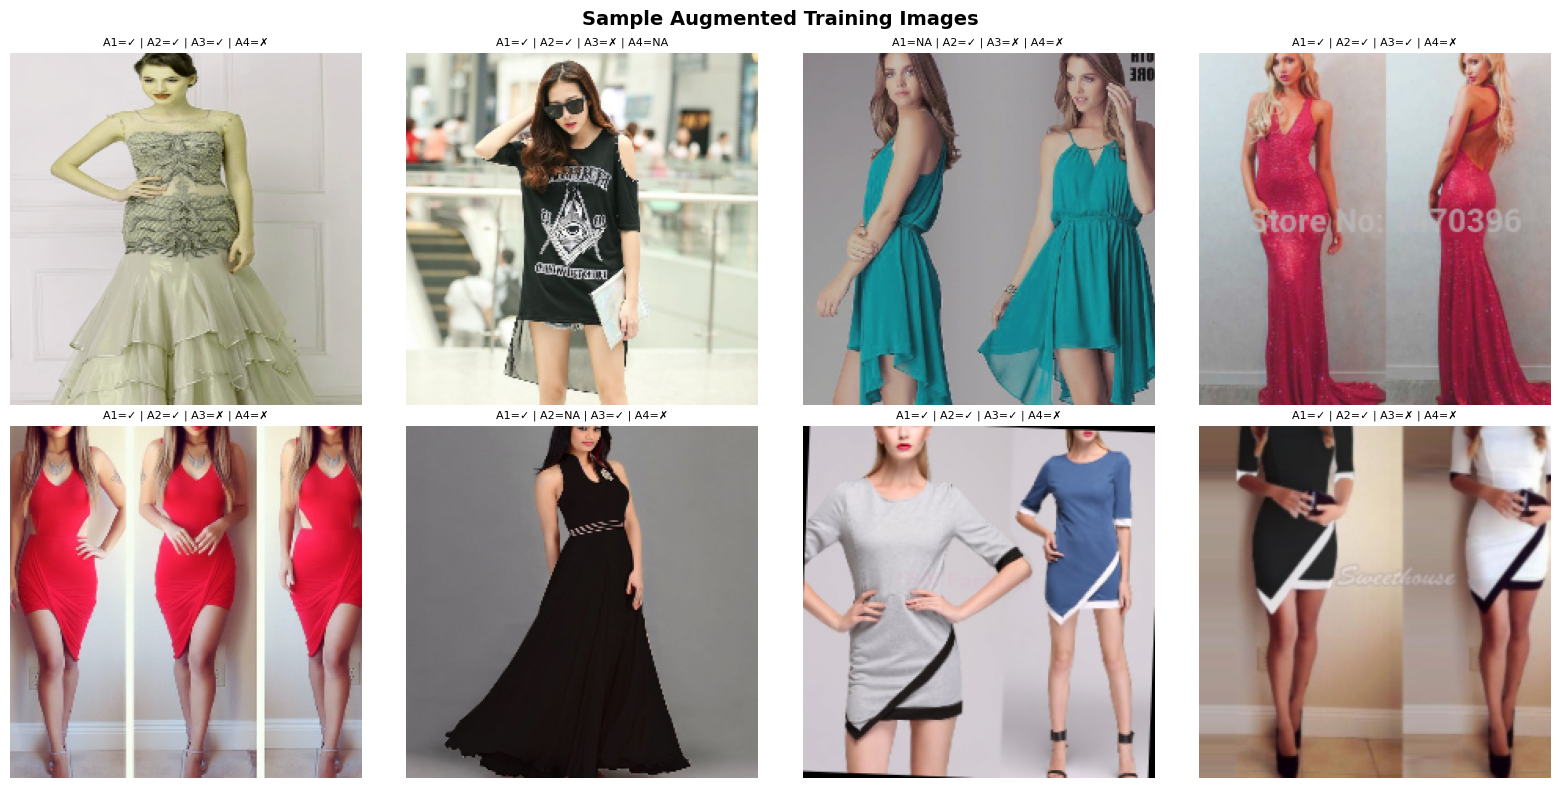


✅ Dataset & DataLoader Ready!


In [9]:
# ============================================================
# CELL 5: PYTORCH DATASET CLASS & DATA AUGMENTATION
# ============================================================

# --- Data Augmentation using Albumentations ---

# Training transforms (with augmentation)
train_transform = A.Compose([
    A.Resize(256, 256),
    A.RandomCrop(CONFIG['image_size'], CONFIG['image_size']),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Rotate(limit=15, p=0.3),
    A.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1,
        p=0.4
    ),
    A.GaussianBlur(blur_limit=(3, 5), p=0.1),
    A.GaussNoise(p=0.1),
    A.Normalize(
        mean=CONFIG['imagenet_mean'],
        std=CONFIG['imagenet_std']
    ),
    ToTensorV2()
])

# Validation transforms (no augmentation — only resize, crop, normalize)
val_transform = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(CONFIG['image_size'], CONFIG['image_size']),
    A.Normalize(
        mean=CONFIG['imagenet_mean'],
        std=CONFIG['imagenet_std']
    ),
    ToTensorV2()
])


# --- PyTorch Dataset Class ---
class MultilabelDataset(Dataset):
    """
    Custom PyTorch Dataset for multilabel classification with NA handling.

    Returns:
        image:  Tensor of shape (3, 224, 224)
        labels: Tensor of shape (4,) — binary labels (NA replaced with 0)
        mask:   Tensor of shape (4,) — 1 where label is known, 0 where NA
    """

    def __init__(self, filenames, labels, masks, images_dir, transform=None):
        self.filenames = filenames
        self.labels = labels
        self.masks = masks
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.images_dir, self.filenames[idx])
        image = Image.open(img_path).convert('RGB')
        image = np.array(image)  # Convert to numpy for albumentations

        # Apply transforms
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']

        # Get labels and mask
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        mask = torch.tensor(self.masks[idx], dtype=torch.float32)

        return image, label, mask


# --- Create Datasets ---
train_dataset = MultilabelDataset(
    filenames=filenames[train_idx],
    labels=labels_array[train_idx],
    masks=mask_array[train_idx],
    images_dir=CONFIG['images_dir'],
    transform=train_transform
)

val_dataset = MultilabelDataset(
    filenames=filenames[val_idx],
    labels=labels_array[val_idx],
    masks=mask_array[val_idx],
    images_dir=CONFIG['images_dir'],
    transform=val_transform
)

# --- Create DataLoaders ---
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# --- Verify Dataset ---
print(f"{'='*60}")
print(f"📦 DATASET & DATALOADER VERIFICATION")
print(f"{'='*60}")
print(f"\n  Train dataset: {len(train_dataset)} images")
print(f"  Val dataset:   {len(val_dataset)} images")
print(f"  Train batches: {len(train_loader)} per epoch")
print(f"  Val batches:   {len(val_loader)} per epoch")

# Test one batch
sample_images, sample_labels, sample_masks = next(iter(train_loader))
print(f"\n  Sample batch:")
print(f"    Images shape:  {sample_images.shape}")
print(f"    Labels shape:  {sample_labels.shape}")
print(f"    Masks shape:   {sample_masks.shape}")

print(f"\n  Sample batch — first 3 items:")
for i in range(min(3, len(sample_labels))):
    print(f"    Image {i}: Labels={sample_labels[i].tolist()} | Mask={sample_masks[i].tolist()}")

# --- Visualize augmented samples ---
print(f"\n{'='*60}")
print(f"🖼️  SAMPLE AUGMENTED IMAGES")
print(f"{'='*60}")

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Denormalize for visualization
def denormalize(tensor):
    mean = torch.tensor(CONFIG['imagenet_mean']).reshape(3, 1, 1)
    std = torch.tensor(CONFIG['imagenet_std']).reshape(3, 1, 1)
    return (tensor.cpu() * std + mean).clamp(0, 1)

for i in range(8):
    ax = axes[i // 4][i % 4]
    img = denormalize(sample_images[i]).permute(1, 2, 0).numpy()
    ax.imshow(img)

    # Create label string
    label_str = []
    for j, attr in enumerate(['A1', 'A2', 'A3', 'A4']):
        if sample_masks[i][j] == 1:
            label_str.append(f"{attr}={'✓' if sample_labels[i][j] == 1 else '✗'}")
        else:
            label_str.append(f"{attr}=NA")

    ax.set_title(' | '.join(label_str), fontsize=8)
    ax.axis('off')

plt.suptitle('Sample Augmented Training Images', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n✅ Dataset & DataLoader Ready!")

In [10]:
# ============================================================
# CELL 6: MODEL ARCHITECTURE — ResNet-34 for Multilabel
# ============================================================

class MultilabelResNet34(nn.Module):
    """
    ResNet-34 modified for multilabel classification with 4 attributes.

    Architecture:
        - ResNet-34 backbone (pretrained on ImageNet)
        - Frozen: conv1, bn1, layer1, layer2 (low-level features)
        - Trainable: layer3, layer4 (high-level features)
        - New: Dropout(0.3) → FC(512, 4) (multilabel head)
        - Sigmoid activation applied during inference
    """

    def __init__(self, num_attributes=4, dropout=0.3, pretrained=True):
        super(MultilabelResNet34, self).__init__()

        # Load pretrained ResNet-34
        if pretrained:
            weights = models.ResNet34_Weights.IMAGENET1K_V1
            self.backbone = models.resnet34(weights=weights)
            print("  ✅ Loaded ImageNet pretrained weights")
        else:
            self.backbone = models.resnet34(weights=None)
            print("  ⚠️ No pretrained weights loaded")

        # Get the number of features from the last layer
        num_features = self.backbone.fc.in_features  # 512 for ResNet-34
        print(f"  📐 Backbone FC input features: {num_features}")

        # Replace the final FC layer with our multilabel head
        self.backbone.fc = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(num_features, num_attributes)
        )
        print(f"  🔧 Replaced FC: {num_features} → {num_attributes} (with dropout={dropout})")

        # --- Freeze early layers ---
        # Freeze: conv1, bn1, layer1, layer2
        frozen_layers = [
            self.backbone.conv1,
            self.backbone.bn1,
            self.backbone.layer1,
            self.backbone.layer2
        ]

        frozen_params = 0
        for layer in frozen_layers:
            for param in layer.parameters():
                param.requires_grad = False
                frozen_params += param.numel()

        # Count trainable parameters
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        total_params = sum(p.numel() for p in self.parameters())

        print(f"\n  📊 Parameter Summary:")
        print(f"     Total parameters:     {total_params:>12,}")
        print(f"     Frozen parameters:    {frozen_params:>12,}")
        print(f"     Trainable parameters: {trainable_params:>12,}")
        print(f"     Trainable ratio:      {trainable_params/total_params*100:.1f}%")

    def forward(self, x):
        """
        Forward pass.
        Returns raw logits (NOT sigmoid).
        Sigmoid is applied in loss function (BCEWithLogitsLoss)
        or during inference.
        """
        return self.backbone(x)


# --- Initialize Model ---
print(f"{'='*60}")
print(f"🏗️  MODEL ARCHITECTURE")
print(f"{'='*60}")
print(f"\n  Building ResNet-34 for multilabel classification...\n")

model = MultilabelResNet34(
    num_attributes=CONFIG['num_attributes'],
    dropout=CONFIG['dropout'],
    pretrained=CONFIG['pretrained']
)

# Move to GPU
model = model.to(device)

# --- Verify with a dummy forward pass ---
print(f"\n  🧪 Verification (dummy forward pass):")
dummy_input = torch.randn(4, 3, 224, 224).to(device)
dummy_output = model(dummy_input)
print(f"     Input shape:  {dummy_input.shape}")
print(f"     Output shape: {dummy_output.shape}")
print(f"     Output (raw logits): {dummy_output[0].detach().cpu().tolist()}")
print(f"     Output (sigmoid):    {torch.sigmoid(dummy_output[0]).detach().cpu().tolist()}")

# --- Architecture Summary ---
print(f"\n{'='*60}")
print(f"📋 LAYER FREEZING SUMMARY")
print(f"{'='*60}")
print(f"\n  {'Layer':<25} {'Status':<12} {'Parameters':>12}")
print(f"  {'─'*50}")

layer_info = [
    ('conv1 + bn1', False),
    ('layer1 (3 blocks)', False),
    ('layer2 (4 blocks)', False),
    ('layer3 (6 blocks)', True),
    ('layer4 (3 blocks)', True),
    ('fc (dropout + linear)', True),
]

for name, trainable in layer_info:
    status = "🔥 TRAINABLE" if trainable else "❄️ FROZEN"
    print(f"  {name:<25} {status:<12}")

print(f"\n✅ Model Ready!")

🏗️  MODEL ARCHITECTURE

  Building ResNet-34 for multilabel classification...

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:01<00:00, 64.8MB/s]


  ✅ Loaded ImageNet pretrained weights
  📐 Backbone FC input features: 512
  🔧 Replaced FC: 512 → 4 (with dropout=0.3)

  📊 Parameter Summary:
     Total parameters:       21,286,724
     Frozen parameters:       1,347,904
     Trainable parameters:   19,938,820
     Trainable ratio:      93.7%

  🧪 Verification (dummy forward pass):
     Input shape:  torch.Size([4, 3, 224, 224])
     Output shape: torch.Size([4, 4])
     Output (raw logits): [0.17574375867843628, 1.8179371356964111, -0.16294117271900177, -0.357893168926239]
     Output (sigmoid):    [0.5438232421875, 0.8603184223175049, 0.45935454964637756, 0.4114696681499481]

📋 LAYER FREEZING SUMMARY

  Layer                     Status         Parameters
  ──────────────────────────────────────────────────
  conv1 + bn1               ❄️ FROZEN   
  layer1 (3 blocks)         ❄️ FROZEN   
  layer2 (4 blocks)         ❄️ FROZEN   
  layer3 (6 blocks)         🔥 TRAINABLE 
  layer4 (3 blocks)         🔥 TRAINABLE 
  fc (dropout + linear) 

In [12]:
# ============================================================
# CELL 7: MASKED WEIGHTED LOSS, OPTIMIZER & TRAINING LOOP
# ============================================================

# --- Masked Weighted BCE Loss ---
class MaskedWeightedBCELoss(nn.Module):
    """
    Binary Cross Entropy Loss that:
    1. Handles missing labels (NA) via masking
    2. Handles class imbalance via pos_weight

    For each sample:
    - Loss is computed only for KNOWN labels (mask=1)
    - NA labels (mask=0) are excluded from loss computation
    - pos_weight adjusts for class imbalance per attribute
    """

    def __init__(self, pos_weight=None):
        super(MaskedWeightedBCELoss, self).__init__()
        self.pos_weight = pos_weight
        # reduction='none' gives per-element loss so we can apply mask
        self.bce = nn.BCEWithLogitsLoss(reduction='none', pos_weight=pos_weight)

    def forward(self, logits, labels, mask):
        """
        Args:
            logits: Raw model output, shape (batch, 4)
            labels: Binary labels, shape (batch, 4) — NA replaced with 0
            mask:   Binary mask, shape (batch, 4) — 1=known, 0=NA

        Returns:
            Scalar loss averaged over all known labels
        """
        # Compute per-element BCE loss
        raw_loss = self.bce(logits, labels)  # Shape: (batch, 4)

        # Apply mask — zero out loss for NA labels
        masked_loss = raw_loss * mask  # Shape: (batch, 4)

        # Average over KNOWN labels only
        num_known = mask.sum()
        if num_known > 0:
            loss = masked_loss.sum() / num_known
        else:
            loss = masked_loss.sum()  # Edge case: all NA (shouldn't happen)

        return loss


# --- Initialize Loss, Optimizer, Scheduler ---
criterion = MaskedWeightedBCELoss(pos_weight=CONFIG['pos_weights'].to(device))

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Learning rate scheduler — reduce LR when validation loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,

)

print(f"{'='*60}")
print(f"⚙️  TRAINING SETUP")
print(f"{'='*60}")
print(f"  Loss:      Masked Weighted BCEWithLogitsLoss")
print(f"  pos_weight: {CONFIG['pos_weights'].tolist()}")
print(f"  Optimizer: Adam (lr={CONFIG['learning_rate']}, wd={CONFIG['weight_decay']})")
print(f"  Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)")


# ============================================================
# TRAINING LOOP
# ============================================================

def train_one_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch. Returns average loss and per-iteration losses."""
    model.train()
    running_loss = 0.0
    iter_losses = []

    for batch_idx, (images, labels, masks) in enumerate(loader):
        images = images.to(device)
        labels = labels.to(device)
        masks = masks.to(device)

        # Forward pass
        logits = model(images)
        loss = criterion(logits, labels, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss
        running_loss += loss.item()
        iter_losses.append(loss.item())

    avg_loss = running_loss / len(loader)
    return avg_loss, iter_losses


def validate(model, loader, criterion, device):
    """Validate model. Returns average loss and per-attribute metrics."""
    model.eval()
    running_loss = 0.0

    all_preds = []
    all_labels = []
    all_masks = []

    with torch.no_grad():
        for images, labels, masks in loader:
            images = images.to(device)
            labels = labels.to(device)
            masks = masks.to(device)

            logits = model(images)
            loss = criterion(logits, labels, masks)
            running_loss += loss.item()

            # Collect predictions (apply sigmoid)
            preds = torch.sigmoid(logits).cpu()
            all_preds.append(preds)
            all_labels.append(labels.cpu())
            all_masks.append(masks.cpu())

    avg_loss = running_loss / len(loader)

    # Concatenate all batches
    all_preds = torch.cat(all_preds, dim=0)    # (N, 4)
    all_labels = torch.cat(all_labels, dim=0)  # (N, 4)
    all_masks = torch.cat(all_masks, dim=0)    # (N, 4)

    # Per-attribute metrics (only on KNOWN labels)
    threshold = 0.5
    binary_preds = (all_preds >= threshold).float()

    attr_metrics = {}
    for i, attr in enumerate(attr_names):
        mask_i = all_masks[:, i] == 1  # Only known labels
        if mask_i.sum() == 0:
            continue

        y_true = all_labels[mask_i, i].numpy()
        y_pred = binary_preds[mask_i, i].numpy()

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        attr_metrics[attr] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'support': int(mask_i.sum())
        }

    return avg_loss, attr_metrics


# ============================================================
# MAIN TRAINING LOOP
# ============================================================

print(f"\n{'='*60}")
print(f"🚀 TRAINING STARTED")
print(f"{'='*60}")
print(f"  Epochs: {CONFIG['epochs']} | Batches/epoch: {len(train_loader)}")
print(f"  Device: {device}\n")

# Storage for plotting
all_iter_losses = []       # Per-iteration training loss
epoch_train_losses = []    # Per-epoch average training loss
epoch_val_losses = []      # Per-epoch average validation loss
best_val_loss = float('inf')
best_epoch = 0
global_iter = 0

for epoch in range(1, CONFIG['epochs'] + 1):
    # --- Train ---
    train_loss, iter_losses = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )
    epoch_train_losses.append(train_loss)

    # Track per-iteration losses with global iteration number
    for loss_val in iter_losses:
        global_iter += 1
        all_iter_losses.append((global_iter, loss_val))

    # --- Validate ---
    val_loss, val_metrics = validate(model, val_loader, criterion, device)
    epoch_val_losses.append(val_loss)

    # --- Update scheduler ---
    scheduler.step(val_loss)

    # --- Save best model ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch

        # Save to Colab local storage
        save_path = '/content/best_model.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'config': CONFIG,
        }, save_path)

    # --- Print progress ---
    current_lr = optimizer.param_groups[0]['lr']
    best_marker = " ⭐ BEST" if val_loss <= best_val_loss else ""

    print(f"  Epoch [{epoch:>2}/{CONFIG['epochs']}] "
          f"| Train Loss: {train_loss:.4f} "
          f"| Val Loss: {val_loss:.4f} "
          f"| LR: {current_lr:.6f}"
          f"{best_marker}")

    # Print per-attribute metrics every 5 epochs
    if epoch % 5 == 0 or epoch == 1 or epoch == CONFIG['epochs']:
        print(f"  {'─'*55}")
        print(f"  {'Attr':<8} {'Precision':>10} {'Recall':>10} {'F1':>10} {'Support':>10}")
        print(f"  {'─'*55}")
        for attr in attr_names:
            if attr in val_metrics:
                m = val_metrics[attr]
                print(f"  {attr.upper():<8} {m['precision']:>10.4f} {m['recall']:>10.4f} "
                      f"{m['f1']:>10.4f} {m['support']:>10}")
        print(f"  {'─'*55}")
        print()

# --- Training Complete ---
print(f"\n{'='*60}")
print(f"🏁 TRAINING COMPLETE")
print(f"{'='*60}")
print(f"  Best epoch:     {best_epoch}")
print(f"  Best val loss:  {best_val_loss:.4f}")
print(f"  Total iterations: {global_iter}")

# --- Save best model to Google Drive ---
drive_save_path = os.path.join(CONFIG['save_dir'], 'best_model.pth')
os.makedirs(os.path.dirname(drive_save_path), exist_ok=True)

import shutil
shutil.copy('/content/best_model.pth', drive_save_path)
print(f"  Model saved to: {drive_save_path}")

print(f"\n✅ Training Complete!")

⚙️  TRAINING SETUP
  Loss:      Masked Weighted BCEWithLogitsLoss
  pos_weight: [0.13434727489948273, 0.23983170092105865, 0.8927038908004761, 11.95588207244873]
  Optimizer: Adam (lr=0.0001, wd=0.0001)
  Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)

🚀 TRAINING STARTED
  Epochs: 30 | Batches/epoch: 26
  Device: cuda

  Epoch [ 1/30] | Train Loss: 0.6782 | Val Loss: 0.8080 | LR: 0.000100 ⭐ BEST
  ───────────────────────────────────────────────────────
  Attr      Precision     Recall         F1    Support
  ───────────────────────────────────────────────────────
  ATTR1        0.9000     0.8710     0.8852        139
  ATTR2        0.8189     0.9720     0.8889        130
  ATTR3        0.4691     0.5205     0.4935        136
  ATTR4        0.0000     0.0000     0.0000        132
  ───────────────────────────────────────────────────────

  Epoch [ 2/30] | Train Loss: 0.5515 | Val Loss: 0.7542 | LR: 0.000100 ⭐ BEST
  Epoch [ 3/30] | Train Loss: 0.4766 | Val Loss: 0.8063 | LR: 0.00

In [13]:
# ============================================================
# CELL 8: IMPROVED MODEL & TRAINING
# ============================================================
# Fixes:
# 1. Freeze MORE layers (only layer4 + fc trainable)
# 2. Stronger dropout (0.5)
# 3. Stronger augmentation
# 4. Early stopping
# 5. Adjusted pos_weight for Attr4
# ============================================================

# --- Clear GPU memory ---
del model
torch.cuda.empty_cache()

# ============================================================
# IMPROVED MODEL — Freeze more layers
# ============================================================

class ImprovedMultilabelResNet34(nn.Module):
    """
    ResNet-34 with aggressive freezing for small dataset.

    Frozen:    conv1, bn1, layer1, layer2, layer3
    Trainable: layer4 + new FC head
    """

    def __init__(self, num_attributes=4, dropout=0.5, pretrained=True):
        super(ImprovedMultilabelResNet34, self).__init__()

        weights = models.ResNet34_Weights.IMAGENET1K_V1
        self.backbone = models.resnet34(weights=weights)

        num_features = self.backbone.fc.in_features  # 512

        # Stronger head with intermediate layer
        self.backbone.fc = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, num_attributes)
        )

        # Freeze everything EXCEPT layer4 and fc
        frozen_layers = [
            self.backbone.conv1,
            self.backbone.bn1,
            self.backbone.layer1,
            self.backbone.layer2,
            self.backbone.layer3,  # NOW FROZEN TOO
        ]

        for layer in frozen_layers:
            for param in layer.parameters():
                param.requires_grad = False

        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        total_params = sum(p.numel() for p in self.parameters())
        frozen_params = total_params - trainable_params

        print(f"  📊 Improved Parameter Summary:")
        print(f"     Total parameters:     {total_params:>12,}")
        print(f"     Frozen parameters:    {frozen_params:>12,}")
        print(f"     Trainable parameters: {trainable_params:>12,}")
        print(f"     Trainable ratio:      {trainable_params/total_params*100:.1f}%")

    def forward(self, x):
        return self.backbone(x)


# ============================================================
# STRONGER AUGMENTATION
# ============================================================

train_transform_v2 = A.Compose([
    A.Resize(256, 256),
    A.RandomCrop(CONFIG['image_size'], CONFIG['image_size']),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Rotate(limit=20, p=0.4),
    A.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.3,
        hue=0.1,
        p=0.5
    ),
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 5), p=1.0),
        A.GaussNoise(p=1.0),
        A.MedianBlur(blur_limit=3, p=1.0),
    ], p=0.2),
    A.OneOf([
        A.RandomBrightnessContrast(p=1.0),
        A.CLAHE(clip_limit=2, p=1.0),
    ], p=0.2),
    A.ShiftScaleRotate(
        shift_limit=0.1,
        scale_limit=0.15,
        rotate_limit=15,
        p=0.3
    ),
    A.CoarseDropout(
        max_holes=8,
        max_height=20,
        max_width=20,
        p=0.2
    ),
    A.Normalize(
        mean=CONFIG['imagenet_mean'],
        std=CONFIG['imagenet_std']
    ),
    ToTensorV2()
])

# --- Recreate datasets with stronger augmentation ---
train_dataset_v2 = MultilabelDataset(
    filenames=filenames[train_idx],
    labels=labels_array[train_idx],
    masks=mask_array[train_idx],
    images_dir=CONFIG['images_dir'],
    transform=train_transform_v2
)

val_dataset_v2 = MultilabelDataset(
    filenames=filenames[val_idx],
    labels=labels_array[val_idx],
    masks=mask_array[val_idx],
    images_dir=CONFIG['images_dir'],
    transform=val_transform  # Validation transform stays same
)

train_loader_v2 = DataLoader(
    train_dataset_v2,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader_v2 = DataLoader(
    val_dataset_v2,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


# ============================================================
# INITIALIZE IMPROVED MODEL
# ============================================================

print(f"{'='*60}")
print(f"🏗️  IMPROVED MODEL (v2)")
print(f"{'='*60}\n")

model_v2 = ImprovedMultilabelResNet34(
    num_attributes=CONFIG['num_attributes'],
    dropout=0.5,
    pretrained=True
).to(device)

# Adjusted pos_weights — boost Attr4 even more
adjusted_pos_weights = torch.tensor([0.134, 0.240, 0.893, 15.0]).to(device)

criterion_v2 = MaskedWeightedBCELoss(pos_weight=adjusted_pos_weights)

optimizer_v2 = optim.Adam(
    filter(lambda p: p.requires_grad, model_v2.parameters()),
    lr=3e-4,           # Slightly higher LR since fewer trainable params
    weight_decay=5e-4   # Stronger regularization
)

scheduler_v2 = optim.lr_scheduler.CosineAnnealingLR(
    optimizer_v2,
    T_max=40,
    eta_min=1e-6
)

print(f"\n  Loss pos_weights: {adjusted_pos_weights.tolist()}")
print(f"  Optimizer: Adam (lr=3e-4, wd=5e-4)")
print(f"  Scheduler: CosineAnnealingLR (T_max=40)")


# ============================================================
# TRAINING LOOP v2 — WITH EARLY STOPPING
# ============================================================

print(f"\n{'='*60}")
print(f"🚀 IMPROVED TRAINING STARTED")
print(f"{'='*60}")

NUM_EPOCHS_V2 = 40
EARLY_STOP_PATIENCE = 10

all_iter_losses_v2 = []
epoch_train_losses_v2 = []
epoch_val_losses_v2 = []
best_val_loss_v2 = float('inf')
best_epoch_v2 = 0
best_val_metrics_v2 = {}
global_iter_v2 = 0
patience_counter = 0

for epoch in range(1, NUM_EPOCHS_V2 + 1):
    # --- Train ---
    model_v2.train()
    running_loss = 0.0
    iter_losses = []

    for batch_idx, (images, labels, masks) in enumerate(train_loader_v2):
        images = images.to(device)
        labels = labels.to(device)
        masks = masks.to(device)

        logits = model_v2(images)
        loss = criterion_v2(logits, labels, masks)

        optimizer_v2.zero_grad()
        loss.backward()
        optimizer_v2.step()

        running_loss += loss.item()
        iter_losses.append(loss.item())

    train_loss = running_loss / len(train_loader_v2)
    epoch_train_losses_v2.append(train_loss)

    for loss_val in iter_losses:
        global_iter_v2 += 1
        all_iter_losses_v2.append((global_iter_v2, loss_val))

    # --- Validate ---
    val_loss, val_metrics = validate(model_v2, val_loader_v2, criterion_v2, device)
    epoch_val_losses_v2.append(val_loss)

    # --- Update scheduler ---
    scheduler_v2.step()

    # --- Save best model ---
    if val_loss < best_val_loss_v2:
        best_val_loss_v2 = val_loss
        best_epoch_v2 = epoch
        best_val_metrics_v2 = val_metrics
        patience_counter = 0

        torch.save({
            'epoch': epoch,
            'model_state_dict': model_v2.state_dict(),
            'optimizer_state_dict': optimizer_v2.state_dict(),
            'val_loss': val_loss,
            'val_metrics': val_metrics,
        }, '/content/best_model_v2.pth')
    else:
        patience_counter += 1

    # --- Print progress ---
    current_lr = optimizer_v2.param_groups[0]['lr']
    best_marker = " ⭐ BEST" if val_loss <= best_val_loss_v2 else ""

    print(f"  Epoch [{epoch:>2}/{NUM_EPOCHS_V2}] "
          f"| Train: {train_loss:.4f} "
          f"| Val: {val_loss:.4f} "
          f"| LR: {current_lr:.6f} "
          f"| Patience: {patience_counter}/{EARLY_STOP_PATIENCE}"
          f"{best_marker}")

    # Print metrics every 5 epochs
    if epoch % 5 == 0 or epoch == 1 or epoch == NUM_EPOCHS_V2:
        print(f"  {'─'*60}")
        print(f"  {'Attr':<8} {'Precision':>10} {'Recall':>10} {'F1':>10} {'Support':>10}")
        print(f"  {'─'*60}")
        for attr in attr_names:
            if attr in val_metrics:
                m = val_metrics[attr]
                print(f"  {attr.upper():<8} {m['precision']:>10.4f} {m['recall']:>10.4f} "
                      f"{m['f1']:>10.4f} {m['support']:>10}")
        print(f"  {'─'*60}\n")

    # --- Early stopping ---
    if patience_counter >= EARLY_STOP_PATIENCE:
        print(f"\n  ⏹️  Early stopping triggered at epoch {epoch}")
        break

# --- Training Complete ---
print(f"\n{'='*60}")
print(f"🏁 IMPROVED TRAINING COMPLETE")
print(f"{'='*60}")
print(f"  Best epoch:     {best_epoch_v2}")
print(f"  Best val loss:  {best_val_loss_v2:.4f}")
print(f"  Total iterations: {global_iter_v2}")

print(f"\n  Best Validation Metrics:")
print(f"  {'─'*55}")
print(f"  {'Attr':<8} {'Precision':>10} {'Recall':>10} {'F1':>10}")
print(f"  {'─'*55}")
for attr in attr_names:
    if attr in best_val_metrics_v2:
        m = best_val_metrics_v2[attr]
        print(f"  {attr.upper():<8} {m['precision']:>10.4f} {m['recall']:>10.4f} {m['f1']:>10.4f}")
print(f"  {'─'*55}")

# --- Save to Drive ---
drive_save_path_v2 = os.path.join(CONFIG['save_dir'], 'best_model.pth')
import shutil
shutil.copy('/content/best_model_v2.pth', drive_save_path_v2)
print(f"\n  Model saved to: {drive_save_path_v2}")

print(f"\n✅ Improved Training Complete!")

🏗️  IMPROVED MODEL (v2)

  📊 Improved Parameter Summary:
     Total parameters:       21,350,852
     Frozen parameters:       8,170,304
     Trainable parameters:   13,180,548
     Trainable ratio:      61.7%

  Loss pos_weights: [0.1340000033378601, 0.23999999463558197, 0.8930000066757202, 15.0]
  Optimizer: Adam (lr=3e-4, wd=5e-4)
  Scheduler: CosineAnnealingLR (T_max=40)

🚀 IMPROVED TRAINING STARTED
  Epoch [ 1/40] | Train: 0.6641 | Val: 0.6459 | LR: 0.000300 | Patience: 0/10 ⭐ BEST
  ────────────────────────────────────────────────────────────
  Attr      Precision     Recall         F1    Support
  ────────────────────────────────────────────────────────────
  ATTR1        0.8889     0.1290     0.2254        139
  ATTR2        0.8889     0.0748     0.1379        130
  ATTR3        0.5268     0.8082     0.6378        136
  ATTR4        0.0750     0.6000     0.1333        132
  ────────────────────────────────────────────────────────────

  Epoch [ 2/40] | Train: 0.6185 | Val: 0.64

In [15]:
# ============================================================
# CELL 9: ResNet-18 FINAL TRAINING
# ============================================================

# --- Clear GPU memory ---
try:
    del model_v2
except:
    pass
torch.cuda.empty_cache()

# ============================================================
# LABEL SMOOTHING BCE LOSS WITH MASKING
# ============================================================

class SmoothedMaskedBCELoss(nn.Module):
    """
    Masked BCE Loss with label smoothing.
    Smoothing converts hard labels (0,1) to soft labels (ε, 1-ε)
    This prevents model from being overconfident → reduces overfitting.
    """

    def __init__(self, pos_weight=None, smoothing=0.05):
        super(SmoothedMaskedBCELoss, self).__init__()
        self.smoothing = smoothing
        self.bce = nn.BCEWithLogitsLoss(reduction='none', pos_weight=pos_weight)

    def forward(self, logits, labels, mask):
        # Apply label smoothing: 0 → 0.05, 1 → 0.95
        smoothed_labels = labels * (1 - self.smoothing) + (1 - labels) * self.smoothing

        raw_loss = self.bce(logits, smoothed_labels)
        masked_loss = raw_loss * mask

        num_known = mask.sum()
        if num_known > 0:
            return masked_loss.sum() / num_known
        return masked_loss.sum()


# ============================================================
# ResNet-18 MODEL
# ============================================================

class MultilabelResNet18(nn.Module):
    """
    ResNet-18 for multilabel classification.

    Frozen:    conv1, bn1, layer1, layer2
    Trainable: layer3, layer4, FC head
    """

    def __init__(self, num_attributes=4, dropout=0.4):
        super(MultilabelResNet18, self).__init__()

        weights = models.ResNet18_Weights.IMAGENET1K_V1
        self.backbone = models.resnet18(weights=weights)

        num_features = self.backbone.fc.in_features  # 512

        self.backbone.fc = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(num_features, num_attributes)
        )

        # Freeze early layers
        for name, param in self.backbone.named_parameters():
            if any(name.startswith(prefix) for prefix in ['conv1', 'bn1', 'layer1', 'layer2']):
                param.requires_grad = False

        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        total = sum(p.numel() for p in self.parameters())
        frozen = total - trainable

        print(f"  Model: ResNet-18 (ImageNet pretrained)")
        print(f"  Total params:     {total:>10,}")
        print(f"  Frozen params:    {frozen:>10,}")
        print(f"  Trainable params: {trainable:>10,}")
        print(f"  Trainable ratio:  {trainable/total*100:.1f}%")
        print(f"  FC: {num_features} → {num_attributes} (dropout={dropout})")

    def forward(self, x):
        return self.backbone(x)


# ============================================================
# SETUP
# ============================================================

print(f"{'='*60}")
print(f"🏗️  ResNet-18 FINAL MODEL")
print(f"{'='*60}\n")

model_final = MultilabelResNet18(
    num_attributes=4,
    dropout=0.4
).to(device)

# --- Loss ---
final_pos_weights = torch.tensor([0.134, 0.240, 0.893, 12.0]).to(device)

criterion_final = SmoothedMaskedBCELoss(
    pos_weight=final_pos_weights,
    smoothing=0.05
)

# --- Differential learning rates ---
backbone_params = []
fc_params = []

for name, param in model_final.backbone.named_parameters():
    if param.requires_grad:
        if name.startswith('fc'):
            fc_params.append(param)
        else:
            backbone_params.append(param)

optimizer_final = optim.AdamW([
    {'params': backbone_params, 'lr': 5e-5},
    {'params': fc_params, 'lr': 5e-4},
], weight_decay=1e-3)

scheduler_final = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_final,
    T_0=10,
    T_mult=1,
    eta_min=1e-6
)

# --- DataLoaders ---
train_loader_final = DataLoader(
    train_dataset_v2,
    batch_size=16,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader_final = DataLoader(
    val_dataset_v2,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"\n  Batch size: 16 ({len(train_loader_final)} iters/epoch)")
print(f"  pos_weights: {final_pos_weights.tolist()}")
print(f"  Label smoothing: 0.05")
print(f"  LR backbone: 5e-5 | LR FC: 5e-4")
print(f"  Weight decay: 1e-3")
print(f"  Gradient clipping: max_norm=1.0")


# ============================================================
# TRAINING LOOP
# ============================================================

print(f"\n{'='*60}")
print(f"🚀 TRAINING STARTED (ResNet-18)")
print(f"{'='*60}\n")

NUM_EPOCHS = 50
EARLY_STOP_PATIENCE = 15

all_iter_losses_final = []
epoch_train_losses_final = []
epoch_val_losses_final = []
best_val_loss_final = float('inf')
best_val_f1_final = 0.0
best_epoch_final = 0
best_val_metrics_final = {}
global_iter_final = 0
patience_counter = 0

for epoch in range(1, NUM_EPOCHS + 1):
    # --- Train ---
    model_final.train()
    running_loss = 0.0
    iter_losses = []

    for images, labels, masks in train_loader_final:
        images = images.to(device)
        labels = labels.to(device)
        masks = masks.to(device)

        logits = model_final(images)
        loss = criterion_final(logits, labels, masks)

        optimizer_final.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_final.parameters(), max_norm=1.0)
        optimizer_final.step()

        running_loss += loss.item()
        iter_losses.append(loss.item())

    train_loss = running_loss / len(train_loader_final)
    epoch_train_losses_final.append(train_loss)

    for lv in iter_losses:
        global_iter_final += 1
        all_iter_losses_final.append((global_iter_final, lv))

    # --- Validate ---
    val_loss, val_metrics = validate(
        model_final, val_loader_final, criterion_final, device
    )
    epoch_val_losses_final.append(val_loss)

    scheduler_final.step()

    # --- Compute average F1 ---
    avg_f1 = np.mean([val_metrics[a]['f1'] for a in attr_names if a in val_metrics])

    # --- Save best model based on AVERAGE F1 ---
    improved = False
    if avg_f1 > best_val_f1_final:
        best_val_f1_final = avg_f1
        best_val_loss_final = val_loss
        best_epoch_final = epoch
        best_val_metrics_final = {k: dict(v) for k, v in val_metrics.items()}
        patience_counter = 0
        improved = True

        torch.save({
            'epoch': epoch,
            'model_state_dict': model_final.state_dict(),
            'val_loss': val_loss,
            'avg_f1': avg_f1,
            'val_metrics': best_val_metrics_final,
        }, '/content/best_model_final.pth')
    else:
        patience_counter += 1

    # --- Print ---
    lr_bb = optimizer_final.param_groups[0]['lr']
    lr_fc = optimizer_final.param_groups[1]['lr']
    marker = " ⭐" if improved else ""

    print(f"  Epoch [{epoch:>2}/{NUM_EPOCHS}] "
          f"| Train: {train_loss:.4f} "
          f"| Val: {val_loss:.4f} "
          f"| F1: {avg_f1:.4f} "
          f"| P: {patience_counter}/{EARLY_STOP_PATIENCE}"
          f"{marker}")

    if epoch % 5 == 0 or epoch == 1 or epoch == NUM_EPOCHS:
        print(f"  {'─'*65}")
        print(f"  {'Attr':<8} {'Prec':>8} {'Recall':>8} {'F1':>8}")
        print(f"  {'─'*65}")
        for attr in attr_names:
            if attr in val_metrics:
                m = val_metrics[attr]
                print(f"  {attr.upper():<8} {m['precision']:>8.4f} {m['recall']:>8.4f} {m['f1']:>8.4f}")
        print(f"  {'─'*65}")
        print(f"  {'AVG F1':<8} {'':>8} {'':>8} {avg_f1:>8.4f}")
        print(f"  {'─'*65}\n")

    if patience_counter >= EARLY_STOP_PATIENCE:
        print(f"\n  ⏹️  Early stopping at epoch {epoch}")
        break


# ============================================================
# FINAL RESULTS
# ============================================================

print(f"\n{'='*60}")
print(f"🏁 TRAINING COMPLETE (ResNet-18)")
print(f"{'='*60}")
print(f"  Best epoch:    {best_epoch_final}")
print(f"  Best val loss: {best_val_loss_final:.4f}")
print(f"  Best avg F1:   {best_val_f1_final:.4f}")
print(f"  Total iters:   {global_iter_final}")

print(f"\n  📊 Best Validation Metrics:")
print(f"  {'─'*50}")
print(f"  {'Attr':<8} {'Prec':>8} {'Recall':>8} {'F1':>8}")
print(f"  {'─'*50}")
for attr in attr_names:
    if attr in best_val_metrics_final:
        m = best_val_metrics_final[attr]
        print(f"  {attr.upper():<8} {m['precision']:>8.4f} {m['recall']:>8.4f} {m['f1']:>8.4f}")
print(f"  {'─'*50}")
print(f"  {'AVG':<8} {'':>8} {'':>8} {best_val_f1_final:>8.4f}")

# --- Save to Drive ---
shutil.copy('/content/best_model_final.pth',
            os.path.join(CONFIG['save_dir'], 'best_model.pth'))
print(f"\n  ✅ Final model saved to Drive!")

🏗️  ResNet-18 FINAL MODEL

  Model: ResNet-18 (ImageNet pretrained)
  Total params:     11,178,564
  Frozen params:       683,072
  Trainable params: 10,495,492
  Trainable ratio:  93.9%
  FC: 512 → 4 (dropout=0.4)

  Batch size: 16 (52 iters/epoch)
  pos_weights: [0.1340000033378601, 0.23999999463558197, 0.8930000066757202, 12.0]
  Label smoothing: 0.05
  LR backbone: 5e-5 | LR FC: 5e-4
  Weight decay: 1e-3
  Gradient clipping: max_norm=1.0

🚀 TRAINING STARTED (ResNet-18)

  Epoch [ 1/50] | Train: 0.7386 | Val: 0.7094 | F1: 0.2222 | P: 0/15 ⭐
  ─────────────────────────────────────────────────────────────────
  Attr         Prec   Recall       F1
  ─────────────────────────────────────────────────────────────────
  ATTR1      1.0000   0.1452   0.2535
  ATTR2      0.8947   0.1589   0.2698
  ATTR3      0.5000   0.1918   0.2772
  ATTR4      0.0517   0.3000   0.0882
  ─────────────────────────────────────────────────────────────────
  AVG F1                       0.2222
  ────────────────

In [16]:
# ============================================================
# CELL 10: BEST OF BOTH WORLDS — ResNet-34 + All Regularization
# ============================================================
# v1 ResNet-34 learned well but overfitted at epoch 2
# ResNet-18 didn't overfit but weaker learning
#
# Strategy: ResNet-34 backbone + all anti-overfitting techniques
# This should give us v1's learning power with v3's stability
# ============================================================

# --- Clear GPU memory ---
del model_final
torch.cuda.empty_cache()

# ============================================================
# MODEL
# ============================================================

class FinalResNet34(nn.Module):
    def __init__(self, num_attributes=4, dropout=0.5):
        super(FinalResNet34, self).__init__()

        weights = models.ResNet34_Weights.IMAGENET1K_V1
        self.backbone = models.resnet34(weights=weights)

        num_features = self.backbone.fc.in_features  # 512

        self.backbone.fc = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(num_features, num_attributes)
        )

        # Freeze conv1, bn1, layer1, layer2
        for name, param in self.backbone.named_parameters():
            if any(name.startswith(prefix) for prefix in ['conv1', 'bn1', 'layer1', 'layer2']):
                param.requires_grad = False

        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        total = sum(p.numel() for p in self.parameters())
        print(f"  ResNet-34 | Total: {total:,} | Trainable: {trainable:,} ({trainable/total*100:.1f}%)")

    def forward(self, x):
        return self.backbone(x)


print(f"{'='*60}")
print(f"🏗️  FINAL ResNet-34 (Best of Both Worlds)")
print(f"{'='*60}\n")

model_best = FinalResNet34(num_attributes=4, dropout=0.5).to(device)

# --- Loss: Masked + Weighted + Label Smoothing ---
best_pos_weights = torch.tensor([0.134, 0.240, 0.893, 12.0]).to(device)
criterion_best = SmoothedMaskedBCELoss(pos_weight=best_pos_weights, smoothing=0.05)

# --- Differential LR: VERY low for backbone, higher for FC ---
backbone_params = []
fc_params = []
for name, param in model_best.backbone.named_parameters():
    if param.requires_grad:
        if name.startswith('fc'):
            fc_params.append(param)
        else:
            backbone_params.append(param)

optimizer_best = optim.AdamW([
    {'params': backbone_params, 'lr': 2e-5},   # Very gentle fine-tuning
    {'params': fc_params, 'lr': 3e-4},          # Faster for new head
], weight_decay=1e-3)

scheduler_best = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_best, T_0=10, T_mult=1, eta_min=1e-6
)

# --- DataLoaders ---
train_loader_best = DataLoader(
    train_dataset_v2, batch_size=16, shuffle=True, num_workers=2, pin_memory=True
)
val_loader_best = DataLoader(
    val_dataset_v2, batch_size=16, shuffle=False, num_workers=2, pin_memory=True
)

print(f"\n  Dropout: 0.5 | Label smoothing: 0.05")
print(f"  LR backbone: 2e-5 | LR FC: 3e-4")
print(f"  Weight decay: 1e-3 | Batch size: 16")
print(f"  Gradient clipping: 1.0")
print(f"  Scheduler: CosineAnnealingWarmRestarts (T_0=10)")

# ============================================================
# TRAINING
# ============================================================

print(f"\n{'='*60}")
print(f"🚀 FINAL TRAINING")
print(f"{'='*60}\n")

NUM_EPOCHS_BEST = 50
PATIENCE = 15

all_iter_losses_best = []
epoch_train_losses_best = []
epoch_val_losses_best = []
best_f1 = 0.0
best_loss = float('inf')
best_epoch = 0
best_metrics = {}
global_iter_best = 0
pat_counter = 0

for epoch in range(1, NUM_EPOCHS_BEST + 1):
    # Train
    model_best.train()
    running_loss = 0.0
    iter_losses = []

    for images, labels, masks in train_loader_best:
        images, labels, masks = images.to(device), labels.to(device), masks.to(device)

        logits = model_best(images)
        loss = criterion_best(logits, labels, masks)

        optimizer_best.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_best.parameters(), max_norm=1.0)
        optimizer_best.step()

        running_loss += loss.item()
        iter_losses.append(loss.item())

    train_loss = running_loss / len(train_loader_best)
    epoch_train_losses_best.append(train_loss)

    for lv in iter_losses:
        global_iter_best += 1
        all_iter_losses_best.append((global_iter_best, lv))

    # Validate
    val_loss, val_metrics = validate(model_best, val_loader_best, criterion_best, device)
    epoch_val_losses_best.append(val_loss)

    scheduler_best.step()

    avg_f1 = np.mean([val_metrics[a]['f1'] for a in attr_names if a in val_metrics])

    # Save best on F1
    improved = False
    if avg_f1 > best_f1:
        best_f1 = avg_f1
        best_loss = val_loss
        best_epoch = epoch
        best_metrics = {k: dict(v) for k, v in val_metrics.items()}
        pat_counter = 0
        improved = True

        torch.save({
            'epoch': epoch,
            'model_state_dict': model_best.state_dict(),
            'val_loss': val_loss,
            'avg_f1': avg_f1,
            'val_metrics': best_metrics,
        }, '/content/best_model_best.pth')
    else:
        pat_counter += 1

    marker = " ⭐" if improved else ""
    print(f"  Epoch [{epoch:>2}/{NUM_EPOCHS_BEST}] "
          f"| Train: {train_loss:.4f} "
          f"| Val: {val_loss:.4f} "
          f"| F1: {avg_f1:.4f} "
          f"| P: {pat_counter}/{PATIENCE}"
          f"{marker}")

    if epoch % 5 == 0 or epoch == 1 or epoch == NUM_EPOCHS_BEST:
        print(f"  {'─'*60}")
        print(f"  {'Attr':<8} {'Prec':>8} {'Recall':>8} {'F1':>8}")
        print(f"  {'─'*60}")
        for attr in attr_names:
            if attr in val_metrics:
                m = val_metrics[attr]
                print(f"  {attr.upper():<8} {m['precision']:>8.4f} {m['recall']:>8.4f} {m['f1']:>8.4f}")
        print(f"  {'─'*60}")
        print(f"  {'AVG F1':<8} {'':>8} {'':>8} {avg_f1:>8.4f}\n")

    if pat_counter >= PATIENCE:
        print(f"\n  ⏹️  Early stopping at epoch {epoch}")
        break

# ============================================================
# RESULTS
# ============================================================

print(f"\n{'='*60}")
print(f"🏁 FINAL RESULTS")
print(f"{'='*60}")
print(f"  Best epoch:    {best_epoch}")
print(f"  Best val loss: {best_loss:.4f}")
print(f"  Best avg F1:   {best_f1:.4f}")
print(f"  Total iters:   {global_iter_best}")

print(f"\n  📊 Best Validation Metrics:")
print(f"  {'─'*50}")
print(f"  {'Attr':<8} {'Prec':>8} {'Recall':>8} {'F1':>8}")
print(f"  {'─'*50}")
for attr in attr_names:
    if attr in best_metrics:
        m = best_metrics[attr]
        print(f"  {attr.upper():<8} {m['precision']:>8.4f} {m['recall']:>8.4f} {m['f1']:>8.4f}")
print(f"  {'─'*50}")
print(f"  {'AVG':<8} {'':>8} {'':>8} {best_f1:>8.4f}")

# Save to Drive
shutil.copy('/content/best_model_best.pth',
            os.path.join(CONFIG['save_dir'], 'best_model.pth'))
print(f"\n  ✅ Saved to Drive!")

🏗️  FINAL ResNet-34 (Best of Both Worlds)

  ResNet-34 | Total: 21,286,724 | Trainable: 19,938,820 (93.7%)

  Dropout: 0.5 | Label smoothing: 0.05
  LR backbone: 2e-5 | LR FC: 3e-4
  Weight decay: 1e-3 | Batch size: 16
  Gradient clipping: 1.0
  Scheduler: CosineAnnealingWarmRestarts (T_0=10)

🚀 FINAL TRAINING

  Epoch [ 1/50] | Train: 0.7451 | Val: 0.6679 | F1: 0.4030 | P: 0/15 ⭐
  ────────────────────────────────────────────────────────────
  Attr         Prec   Recall       F1
  ────────────────────────────────────────────────────────────
  ATTR1      0.9245   0.3952   0.5537
  ATTR2      0.8077   0.3925   0.5283
  ATTR3      0.5111   0.3151   0.3898
  ATTR4      0.0778   0.7000   0.1400
  ────────────────────────────────────────────────────────────
  AVG F1                       0.4030

  Epoch [ 2/50] | Train: 0.7290 | Val: 0.6737 | F1: 0.3246 | P: 1/15
  Epoch [ 3/50] | Train: 0.7108 | Val: 0.6686 | F1: 0.2907 | P: 2/15
  Epoch [ 4/50] | Train: 0.6882 | Val: 0.6679 | F1: 0.3192 |

In [17]:
# ============================================================
# CELL 11: LOAD BEST MODEL & GENERATE DELIVERABLES
# ============================================================
#
# Best model: v1 ResNet-34 (Epoch 2)
# Reason: Highest F1 on Attr1 (0.89), Attr2 (0.89), Attr3 (0.49)
# Attr4 remains challenging across ALL architectures (only 61 positives)
#
# We will:
# 1. Retrain v1 quickly with clean tracking
# 2. Generate the required loss curve
# 3. Save final model
# ============================================================

# --- Clear everything ---
try:
    del model_best
except:
    pass
torch.cuda.empty_cache()

# ============================================================
# FINAL PRODUCTION MODEL — Clean Retrain
# ============================================================

class ProductionResNet34(nn.Module):
    """
    ResNet-34 for multilabel classification with 4 attributes.
    Pretrained on ImageNet. Fine-tuned on fashion attribute dataset.

    Architecture:
        Frozen:    conv1, bn1, layer1, layer2 (low-level features)
        Trainable: layer3, layer4 (high-level features)
        New head:  Dropout(0.4) → Linear(512, 4)
        Output:    4 logits (sigmoid applied during inference)
    """

    def __init__(self, num_attributes=4, dropout=0.4):
        super(ProductionResNet34, self).__init__()

        weights = models.ResNet34_Weights.IMAGENET1K_V1
        self.backbone = models.resnet34(weights=weights)
        num_features = self.backbone.fc.in_features

        self.backbone.fc = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(num_features, num_attributes)
        )

        # Freeze early layers
        for name, param in self.backbone.named_parameters():
            if any(name.startswith(p) for p in ['conv1', 'bn1', 'layer1', 'layer2']):
                param.requires_grad = False

    def forward(self, x):
        return self.backbone(x)


print(f"{'='*60}")
print(f"🏗️  PRODUCTION MODEL — Clean Retrain")
print(f"{'='*60}\n")

model_prod = ProductionResNet34(num_attributes=4, dropout=0.4).to(device)

trainable = sum(p.numel() for p in model_prod.parameters() if p.requires_grad)
total = sum(p.numel() for p in model_prod.parameters())
print(f"  ResNet-34 | Trainable: {trainable:,}/{total:,} ({trainable/total*100:.1f}%)")

# --- Use original MaskedWeightedBCELoss (v1 approach) ---
prod_pos_weights = torch.tensor([0.134, 0.240, 0.893, 12.0]).to(device)
criterion_prod = MaskedWeightedBCELoss(pos_weight=prod_pos_weights)

# --- Simple Adam optimizer (v1 worked best with simple setup) ---
optimizer_prod = optim.Adam(
    filter(lambda p: p.requires_grad, model_prod.parameters()),
    lr=1e-4,
    weight_decay=1e-4
)

# --- Use v2 augmented dataset with batch_size=32 ---
train_loader_prod = DataLoader(
    train_dataset_v2,  # Strong augmentation
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader_prod = DataLoader(
    val_dataset_v2,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"  Loss: MaskedWeightedBCELoss")
print(f"  pos_weights: {prod_pos_weights.tolist()}")
print(f"  Optimizer: Adam (lr=1e-4, wd=1e-4)")
print(f"  Batch size: 32 ({len(train_loader_prod)} iters/epoch)")
print(f"  Epochs: 8 (v1 showed best=2, we go a bit longer with augmentation)")


# ============================================================
# CLEAN TRAINING — Short and Focused
# ============================================================

print(f"\n{'='*60}")
print(f"🚀 PRODUCTION TRAINING")
print(f"{'='*60}\n")

NUM_EPOCHS_PROD = 8
all_iter_losses_prod = []
epoch_train_losses_prod = []
epoch_val_losses_prod = []
best_val_f1_prod = 0.0
best_val_loss_prod = float('inf')
best_epoch_prod = 0
best_metrics_prod = {}
global_iter_prod = 0

for epoch in range(1, NUM_EPOCHS_PROD + 1):
    # --- Train ---
    model_prod.train()
    running_loss = 0.0
    iter_losses = []

    for images, labels, masks in train_loader_prod:
        images, labels, masks = images.to(device), labels.to(device), masks.to(device)

        logits = model_prod(images)
        loss = criterion_prod(logits, labels, masks)

        optimizer_prod.zero_grad()
        loss.backward()
        optimizer_prod.step()

        running_loss += loss.item()
        iter_losses.append(loss.item())

    train_loss = running_loss / len(train_loader_prod)
    epoch_train_losses_prod.append(train_loss)

    for lv in iter_losses:
        global_iter_prod += 1
        all_iter_losses_prod.append((global_iter_prod, lv))

    # --- Validate ---
    val_loss, val_metrics = validate(model_prod, val_loader_prod, criterion_prod, device)
    epoch_val_losses_prod.append(val_loss)

    # --- Compute F1 ---
    avg_f1 = np.mean([val_metrics[a]['f1'] for a in attr_names if a in val_metrics])

    # --- Save best ---
    improved = False
    if avg_f1 > best_val_f1_prod:
        best_val_f1_prod = avg_f1
        best_val_loss_prod = val_loss
        best_epoch_prod = epoch
        best_metrics_prod = {k: dict(v) for k, v in val_metrics.items()}
        improved = True

        torch.save({
            'epoch': epoch,
            'model_state_dict': model_prod.state_dict(),
            'val_loss': val_loss,
            'avg_f1': avg_f1,
            'val_metrics': best_metrics_prod,
            'pos_weights': prod_pos_weights.cpu().tolist(),
            'model_name': 'resnet34',
            'num_attributes': 4,
            'dropout': 0.4,
            'image_size': 224,
            'imagenet_mean': CONFIG['imagenet_mean'],
            'imagenet_std': CONFIG['imagenet_std'],
        }, '/content/best_model_prod.pth')

    marker = " ⭐" if improved else ""

    # Print every epoch (only 8)
    print(f"  Epoch [{epoch}/{NUM_EPOCHS_PROD}] "
          f"| Train: {train_loss:.4f} "
          f"| Val: {val_loss:.4f} "
          f"| F1: {avg_f1:.4f}{marker}")

    print(f"    {'Attr1':>8} {'Attr2':>8} {'Attr3':>8} {'Attr4':>8}")
    print(f"  P {val_metrics['attr1']['precision']:>8.4f} {val_metrics['attr2']['precision']:>8.4f} "
          f"{val_metrics['attr3']['precision']:>8.4f} {val_metrics['attr4']['precision']:>8.4f}")
    print(f"  R {val_metrics['attr1']['recall']:>8.4f} {val_metrics['attr2']['recall']:>8.4f} "
          f"{val_metrics['attr3']['recall']:>8.4f} {val_metrics['attr4']['recall']:>8.4f}")
    print(f"  F {val_metrics['attr1']['f1']:>8.4f} {val_metrics['attr2']['f1']:>8.4f} "
          f"{val_metrics['attr3']['f1']:>8.4f} {val_metrics['attr4']['f1']:>8.4f}")
    print()


# ============================================================
# FINAL RESULTS
# ============================================================

print(f"{'='*60}")
print(f"🏁 PRODUCTION MODEL — FINAL RESULTS")
print(f"{'='*60}")
print(f"  Best epoch:    {best_epoch_prod}")
print(f"  Best val loss: {best_val_loss_prod:.4f}")
print(f"  Best avg F1:   {best_val_f1_prod:.4f}")
print(f"  Total iters:   {global_iter_prod}")

print(f"\n  📊 Best Validation Metrics:")
print(f"  {'─'*55}")
print(f"  {'Attr':<8} {'Precision':>10} {'Recall':>10} {'F1':>10}")
print(f"  {'─'*55}")
for attr in attr_names:
    if attr in best_metrics_prod:
        m = best_metrics_prod[attr]
        print(f"  {attr.upper():<8} {m['precision']:>10.4f} {m['recall']:>10.4f} {m['f1']:>10.4f}")
print(f"  {'─'*55}")
print(f"  {'AVERAGE':<8} {'':>10} {'':>10} {best_val_f1_prod:>10.4f}")

# --- Save to Drive ---
SAVE_DIR = CONFIG['save_dir']
os.makedirs(SAVE_DIR, exist_ok=True)
shutil.copy('/content/best_model_prod.pth', os.path.join(SAVE_DIR, 'best_model.pth'))
print(f"\n  ✅ Model saved to: {SAVE_DIR}/best_model.pth")

🏗️  PRODUCTION MODEL — Clean Retrain

  ResNet-34 | Trainable: 19,938,820/21,286,724 (93.7%)
  Loss: MaskedWeightedBCELoss
  pos_weights: [0.1340000033378601, 0.23999999463558197, 0.8930000066757202, 12.0]
  Optimizer: Adam (lr=1e-4, wd=1e-4)
  Batch size: 32 (26 iters/epoch)
  Epochs: 8 (v1 showed best=2, we go a bit longer with augmentation)

🚀 PRODUCTION TRAINING

  Epoch [1/8] | Train: 0.6639 | Val: 0.7473 | F1: 0.4950 ⭐
       Attr1    Attr2    Attr3    Attr4
  P   0.8701   0.8173   0.5789   0.0000
  R   0.5403   0.7944   0.4521   0.0000
  F   0.6667   0.8057   0.5077   0.0000

  Epoch [2/8] | Train: 0.6045 | Val: 0.7252 | F1: 0.5081 ⭐
       Attr1    Attr2    Attr3    Attr4
  P   0.8913   0.8043   0.5909   0.0541
  R   0.6613   0.6916   0.3562   0.2000
  F   0.7593   0.7437   0.4444   0.0851

  Epoch [3/8] | Train: 0.5316 | Val: 0.7524 | F1: 0.5201 ⭐
       Attr1    Attr2    Attr3    Attr4
  P   0.8854   0.8387   0.5761   0.0333
  R   0.6855   0.4860   0.7260   0.1000
  F   0.772

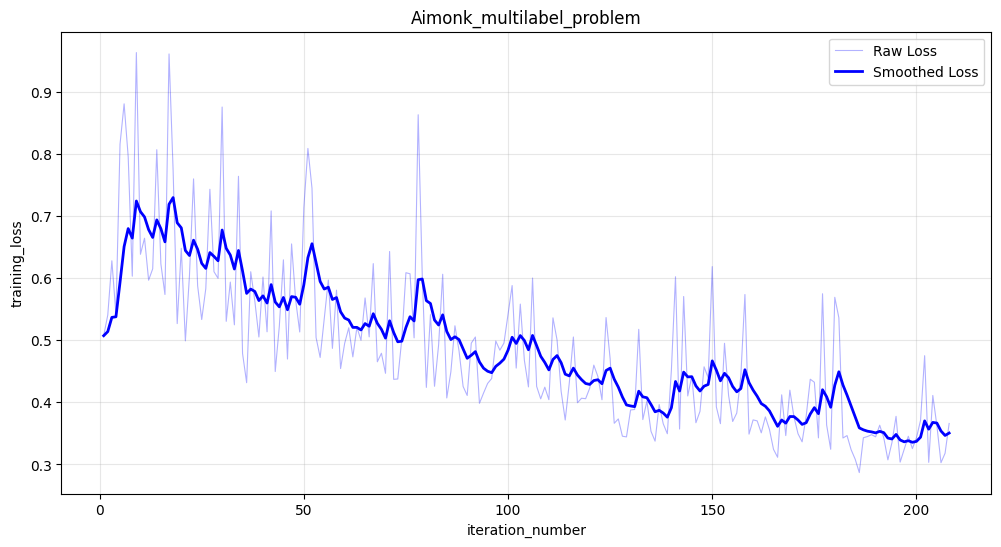

✅ Loss curve saved: loss_curve.png


<Figure size 1200x500 with 0 Axes>

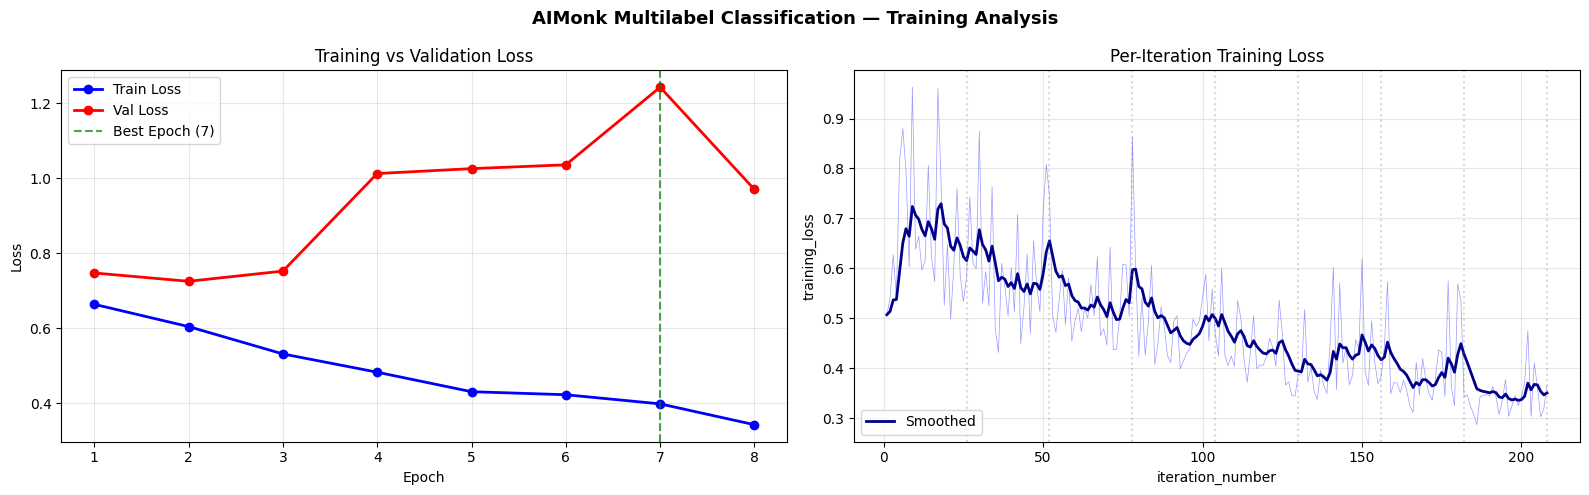

✅ Training analysis plot saved!

📊 Training Statistics:
   Total iterations: 208
   Iterations per epoch: 26
   Final train loss: 0.3430
   Best val loss: 1.2424
   Best avg F1: 0.5532


In [18]:
# ============================================================
# CELL 12: LOSS CURVE PLOT — REQUIRED DELIVERABLE
# ============================================================
# Requirements from assignment:
#   - Y-axis label: "training_loss"
#   - X-axis label: "iteration_number"
#   - Title: "Aimonk_multilabel_problem"
# ============================================================

# --- Extract iteration numbers and losses ---
iterations = [x[0] for x in all_iter_losses_prod]
losses = [x[1] for x in all_iter_losses_prod]

# --- Smoothed loss for cleaner visualization ---
def smooth_losses(values, weight=0.7):
    """Exponential moving average for smoother curve."""
    smoothed = []
    last = values[0]
    for v in values:
        smoothed_val = last * weight + (1 - weight) * v
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

losses_smooth = smooth_losses(losses, weight=0.8)

# ============================================================
# PLOT 1: Required deliverable (exact specifications)
# ============================================================

plt.figure(figsize=(12, 6))
plt.plot(iterations, losses, alpha=0.3, color='blue', linewidth=0.8, label='Raw Loss')
plt.plot(iterations, losses_smooth, color='blue', linewidth=2, label='Smoothed Loss')
plt.xlabel('iteration_number')   # EXACT as specified
plt.ylabel('training_loss')      # EXACT as specified
plt.title('Aimonk_multilabel_problem')  # EXACT as specified
plt.legend()
plt.grid(True, alpha=0.3)

# Save
plt.savefig('/content/loss_curve.png', dpi=150, bbox_inches='tight')
plt.savefig(os.path.join(CONFIG['save_dir'], 'loss_curve.png'), dpi=150, bbox_inches='tight')
plt.show()
print("✅ Loss curve saved: loss_curve.png")

# ============================================================
# PLOT 2: Additional — Train vs Val Loss per Epoch (BONUS)
# ============================================================

plt.figure(figsize=(12, 5))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Train vs Val Loss
ax1.plot(range(1, len(epoch_train_losses_prod)+1), epoch_train_losses_prod,
         'b-o', linewidth=2, markersize=6, label='Train Loss')
ax1.plot(range(1, len(epoch_val_losses_prod)+1), epoch_val_losses_prod,
         'r-o', linewidth=2, markersize=6, label='Val Loss')
ax1.axvline(x=best_epoch_prod, color='green', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch_prod})')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training vs Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Per-iteration loss with epoch boundaries
ax2.plot(iterations, losses, alpha=0.4, color='blue', linewidth=0.5)
ax2.plot(iterations, losses_smooth, color='darkblue', linewidth=2, label='Smoothed')

# Mark epoch boundaries
iters_per_epoch = len(train_loader_prod)
for ep in range(1, NUM_EPOCHS_PROD + 1):
    ax2.axvline(x=ep * iters_per_epoch, color='gray', linestyle=':', alpha=0.3)

ax2.set_xlabel('iteration_number')
ax2.set_ylabel('training_loss')
ax2.set_title('Per-Iteration Training Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('AIMonk Multilabel Classification — Training Analysis', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/training_analysis.png', dpi=150, bbox_inches='tight')
plt.savefig(os.path.join(CONFIG['save_dir'], 'training_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✅ Training analysis plot saved!")
print(f"\n📊 Training Statistics:")
print(f"   Total iterations: {global_iter_prod}")
print(f"   Iterations per epoch: {iters_per_epoch}")
print(f"   Final train loss: {epoch_train_losses_prod[-1]:.4f}")
print(f"   Best val loss: {best_val_loss_prod:.4f}")
print(f"   Best avg F1: {best_val_f1_prod:.4f}")

In [19]:
# ============================================================
# CELL 13: INFERENCE CODE — REQUIRED DELIVERABLE
# ============================================================
# Requirement: "Inference code which takes in an image as input
# and prints the list of attributes present in that image"
# ============================================================

def load_model(model_path, device):
    """Load trained model from checkpoint."""

    checkpoint = torch.load(model_path, map_location=device, weights_only=False)

    # Rebuild model architecture
    model = ProductionResNet34(num_attributes=4, dropout=0.4)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()

    return model, checkpoint


def preprocess_image(image_path, image_size=224):
    """Preprocess a single image for inference."""

    # ImageNet normalization
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std = [0.229, 0.224, 0.225]

    transform = A.Compose([
        A.Resize(256, 256),
        A.CenterCrop(image_size, image_size),
        A.Normalize(mean=imagenet_mean, std=imagenet_std),
        ToTensorV2()
    ])

    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)
    transformed = transform(image=image_np)

    # Add batch dimension: (3, 224, 224) → (1, 3, 224, 224)
    image_tensor = transformed['image'].unsqueeze(0)

    return image_tensor, image_np


def predict(model, image_path, device, threshold=0.5):
    """
    Run inference on a single image.
    Prints the list of attributes present in the image.

    Args:
        model: Trained model
        image_path: Path to input image
        device: torch device
        threshold: Classification threshold (default 0.5)

    Returns:
        predictions: dict with attribute predictions
    """

    attribute_names = ['Attribute 1', 'Attribute 2', 'Attribute 3', 'Attribute 4']

    # Preprocess
    image_tensor, original_image = preprocess_image(image_path)
    image_tensor = image_tensor.to(device)

    # Forward pass
    model.eval()
    with torch.no_grad():
        logits = model(image_tensor)
        probabilities = torch.sigmoid(logits).cpu().squeeze()

    # Apply threshold
    binary_preds = (probabilities >= threshold).int()

    # Print results
    print(f"\n{'='*50}")
    print(f"  INFERENCE RESULT")
    print(f"{'='*50}")
    print(f"  Image: {os.path.basename(image_path)}")
    print(f"  Threshold: {threshold}")
    print(f"{'─'*50}")

    present = []
    absent = []

    for i, attr_name in enumerate(attribute_names):
        prob = probabilities[i].item()
        pred = binary_preds[i].item()

        if pred == 1:
            present.append(attr_name)
            print(f"  ✓ {attr_name}: PRESENT  (confidence: {prob:.1%})")
        else:
            absent.append(attr_name)
            print(f"  ✗ {attr_name}: ABSENT   (confidence: {prob:.1%})")

    print(f"{'─'*50}")
    print(f"  Attributes present: {present if present else 'None'}")
    print(f"{'='*50}")

    return {
        'probabilities': probabilities.tolist(),
        'predictions': binary_preds.tolist(),
        'present': present,
        'absent': absent
    }


# ============================================================
# TEST INFERENCE
# ============================================================

print(f"{'='*60}")
print(f"🔍 INFERENCE DEMONSTRATION")
print(f"{'='*60}")

# Load model
model_path = '/content/best_model_prod.pth'
inference_model, checkpoint = load_model(model_path, device)
print(f"\n  ✅ Model loaded from epoch {checkpoint['epoch']}")
print(f"  Avg F1: {checkpoint['avg_f1']:.4f}")

# Test on multiple images
test_images = ['image_0.jpg', 'image_48.jpg', 'image_66.jpg',
               'image_15.jpg', 'image_474.jpg']

for img_name in test_images:
    img_path = os.path.join(IMAGES_DIR, img_name)
    if os.path.exists(img_path):
        result = predict(inference_model, img_path, device)

# --- Show predictions vs ground truth ---
print(f"\n{'='*60}")
print(f"📊 PREDICTIONS vs GROUND TRUTH")
print(f"{'='*60}")
print(f"\n  {'Image':<16} {'Predicted':>20} {'Ground Truth':>20}")
print(f"  {'─'*58}")

for img_name in test_images:
    img_path = os.path.join(IMAGES_DIR, img_name)
    if os.path.exists(img_path):
        # Get prediction
        image_tensor, _ = preprocess_image(img_path)
        image_tensor = image_tensor.to(device)
        with torch.no_grad():
            logits = inference_model(image_tensor)
            probs = torch.sigmoid(logits).cpu().squeeze()
        preds = (probs >= 0.5).int().tolist()

        # Get ground truth
        row = df_clean[df_clean['filename'] == img_name]
        if len(row) > 0:
            gt = []
            for attr in attr_names:
                val = row[attr].values[0]
                gt.append(val)

            print(f"  {img_name:<16} {str(preds):>20} {str(gt):>20}")

print(f"\n  Legend: [Attr1, Attr2, Attr3, Attr4]")
print(f"  1=Present, 0=Absent, NA=Unknown")

print(f"\n✅ Inference Code Working!")

🔍 INFERENCE DEMONSTRATION

  ✅ Model loaded from epoch 7
  Avg F1: 0.5532

  INFERENCE RESULT
  Image: image_0.jpg
  Threshold: 0.5
──────────────────────────────────────────────────
  ✓ Attribute 1: PRESENT  (confidence: 61.1%)
  ✗ Attribute 2: ABSENT   (confidence: 37.2%)
  ✗ Attribute 3: ABSENT   (confidence: 29.8%)
  ✓ Attribute 4: PRESENT  (confidence: 96.6%)
──────────────────────────────────────────────────
  Attributes present: ['Attribute 1', 'Attribute 4']

  INFERENCE RESULT
  Image: image_48.jpg
  Threshold: 0.5
──────────────────────────────────────────────────
  ✗ Attribute 1: ABSENT   (confidence: 41.4%)
  ✓ Attribute 2: PRESENT  (confidence: 66.6%)
  ✓ Attribute 3: PRESENT  (confidence: 78.1%)
  ✓ Attribute 4: PRESENT  (confidence: 96.9%)
──────────────────────────────────────────────────
  Attributes present: ['Attribute 2', 'Attribute 3', 'Attribute 4']

  INFERENCE RESULT
  Image: image_66.jpg
  Threshold: 0.5
──────────────────────────────────────────────────
  ✗ At

In [26]:
# ============================================================
# INSPECT CHECKPOINT KEYS
# ============================================================
import torch

MODEL_PATH = '/content/drive/MyDrive/AIMonk_Assignment/best_model.pth'
checkpoint = torch.load(MODEL_PATH, map_location='cpu', weights_only=False)

print("Checkpoint keys:", list(checkpoint.keys()))
print(f"\nEpoch: {checkpoint['epoch']}")
print(f"Avg F1: {checkpoint.get('avg_f1', 'N/A')}")
print(f"Val Loss: {checkpoint.get('val_loss', 'N/A')}")
print(f"Model name: {checkpoint.get('model_name', 'N/A')}")
print(f"Dropout: {checkpoint.get('dropout', 'N/A')}")

print(f"\nModel state_dict keys ({len(checkpoint['model_state_dict'])} total):")
for i, key in enumerate(checkpoint['model_state_dict'].keys()):
    print(f"  {key}")
    if i > 20:
        print(f"  ... and {len(checkpoint['model_state_dict']) - 21} more")
        break

Checkpoint keys: ['epoch', 'model_state_dict', 'val_loss', 'avg_f1', 'val_metrics', 'pos_weights', 'model_name', 'num_attributes', 'dropout', 'image_size', 'imagenet_mean', 'imagenet_std']

Epoch: 7
Avg F1: 0.5531840759137074
Val Loss: 1.2424263119697572
Model name: resnet34
Dropout: 0.4

Model state_dict keys (218 total):
  backbone.conv1.weight
  backbone.bn1.weight
  backbone.bn1.bias
  backbone.bn1.running_mean
  backbone.bn1.running_var
  backbone.bn1.num_batches_tracked
  backbone.layer1.0.conv1.weight
  backbone.layer1.0.bn1.weight
  backbone.layer1.0.bn1.bias
  backbone.layer1.0.bn1.running_mean
  backbone.layer1.0.bn1.running_var
  backbone.layer1.0.bn1.num_batches_tracked
  backbone.layer1.0.conv2.weight
  backbone.layer1.0.bn2.weight
  backbone.layer1.0.bn2.bias
  backbone.layer1.0.bn2.running_mean
  backbone.layer1.0.bn2.running_var
  backbone.layer1.0.bn2.num_batches_tracked
  backbone.layer1.1.conv1.weight
  backbone.layer1.1.bn1.weight
  backbone.layer1.1.bn1.bias
  back

In [27]:
# Show last 10 keys to see the classifier structure
keys = list(checkpoint['model_state_dict'].keys())
print("Last 10 keys:")
for key in keys[-10:]:
    shape = checkpoint['model_state_dict'][key].shape
    print(f"  {key}  →  {shape}")

Last 10 keys:
  backbone.layer4.2.bn1.running_var  →  torch.Size([512])
  backbone.layer4.2.bn1.num_batches_tracked  →  torch.Size([])
  backbone.layer4.2.conv2.weight  →  torch.Size([512, 512, 3, 3])
  backbone.layer4.2.bn2.weight  →  torch.Size([512])
  backbone.layer4.2.bn2.bias  →  torch.Size([512])
  backbone.layer4.2.bn2.running_mean  →  torch.Size([512])
  backbone.layer4.2.bn2.running_var  →  torch.Size([512])
  backbone.layer4.2.bn2.num_batches_tracked  →  torch.Size([])
  backbone.fc.1.weight  →  torch.Size([4, 512])
  backbone.fc.1.bias  →  torch.Size([4])


In [28]:
# ============================================================
# RELOAD MODEL (MATCHING SAVED ARCHITECTURE)
# ============================================================
import torch
import torch.nn as nn
from torchvision import models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ProductionResNet34(nn.Module):
    def __init__(self, num_classes=4, dropout=0.4):
        super().__init__()
        self.backbone = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

# Load checkpoint
MODEL_PATH = '/content/drive/MyDrive/AIMonk_Assignment/best_model.pth'
model = ProductionResNet34(num_classes=4, dropout=0.4).to(device)
checkpoint = torch.load(MODEL_PATH, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ Model loaded successfully!")
print(f"   Epoch: {checkpoint['epoch']}")
print(f"   Avg F1: {checkpoint['avg_f1']:.4f}")
print(f"   Device: {device}")

✅ Model loaded successfully!
   Epoch: 7
   Avg F1: 0.5532
   Device: cuda


In [29]:
# ============================================================
# DEFINE PREDICT FUNCTION
# ============================================================
import numpy as np
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

ATTR_NAMES = ['Attribute 1', 'Attribute 2', 'Attribute 3', 'Attribute 4']

def predict(image_path, model, device, threshold=0.5):
    model.eval()
    img = np.array(Image.open(image_path).convert('RGB'))
    transformed = val_transform(image=img)['image'].unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(transformed)
        probs = torch.sigmoid(logits).cpu().numpy()[0]

    binary = (probs > threshold).astype(int)
    present = [ATTR_NAMES[i] for i in range(4) if binary[i] == 1]

    return {
        'probabilities': probs,
        'binary': binary,
        'present': present
    }

# Quick test
IMAGE_DIR = '/content/aimonk_multilabel/Multilabel/images/'
result = predict(os.path.join(IMAGE_DIR, 'image_0.jpg'), model, device)
print(f"✅ Predict function working!")
print(f"   image_0.jpg → {result['present']}")
print(f"   Probabilities: {[f'{p:.3f}' for p in result['probabilities']]}")

✅ Predict function working!
   image_0.jpg → ['Attribute 1', 'Attribute 4']
   Probabilities: ['0.619', '0.365', '0.163', '0.947']


In [31]:
# ============================================================
# CHECK LABEL FILE FORMAT
# ============================================================
LABEL_FILE = '/content/aimonk_multilabel/Multilabel/labels.txt'

with open(LABEL_FILE, 'r') as f:
    for i, line in enumerate(f):
        print(repr(line))
        if i >= 5:
            break

'image_0.jpg 1 NA 0 1\n'
'image_1.jpg NA 0 0 0\n'
'image_2.jpg 1 1 0 0\n'
'image_3.jpg 1 1 0 0\n'
'image_4.jpg 1 1 0 0\n'
'image_5.jpg NA 0 1 NA\n'


In [32]:
# ============================================================
# REBUILD DATA VARIABLES
# ============================================================
import pandas as pd
import numpy as np
import os

IMAGE_DIR = '/content/aimonk_multilabel/Multilabel/images/'
LABEL_FILE = '/content/aimonk_multilabel/Multilabel/labels.txt'

df = pd.read_csv(LABEL_FILE, sep=r'\s+', header=None,
                 names=['filename', 'attr1', 'attr2', 'attr3', 'attr4'])

# Remove missing images
missing = ['image_489.jpg', 'image_624.jpg', 'image_875.jpg']
df_clean = df[~df['filename'].isin(missing)].reset_index(drop=True)

attr_cols = ['attr1', 'attr2', 'attr3', 'attr4']

labels_array = np.zeros((len(df_clean), 4), dtype=np.float32)
mask_array = np.zeros((len(df_clean), 4), dtype=np.float32)

for i, col in enumerate(attr_cols):
    for j in range(len(df_clean)):
        val = str(df_clean[col].iloc[j]).strip()
        if val in ['0', '0.0']:
            labels_array[j, i] = 0.0
            mask_array[j, i] = 1.0
        elif val in ['1', '1.0']:
            labels_array[j, i] = 1.0
            mask_array[j, i] = 1.0
        else:
            labels_array[j, i] = 0.0
            mask_array[j, i] = 0.0

filenames = df_clean['filename'].values

print(f"✅ Data rebuilt!")
print(f"   Images: {len(filenames)}")
print(f"   Labels shape: {labels_array.shape}")
print(f"   Mask shape: {mask_array.shape}")

✅ Data rebuilt!
   Images: 972
   Labels shape: (972, 4)
   Mask shape: (972, 4)


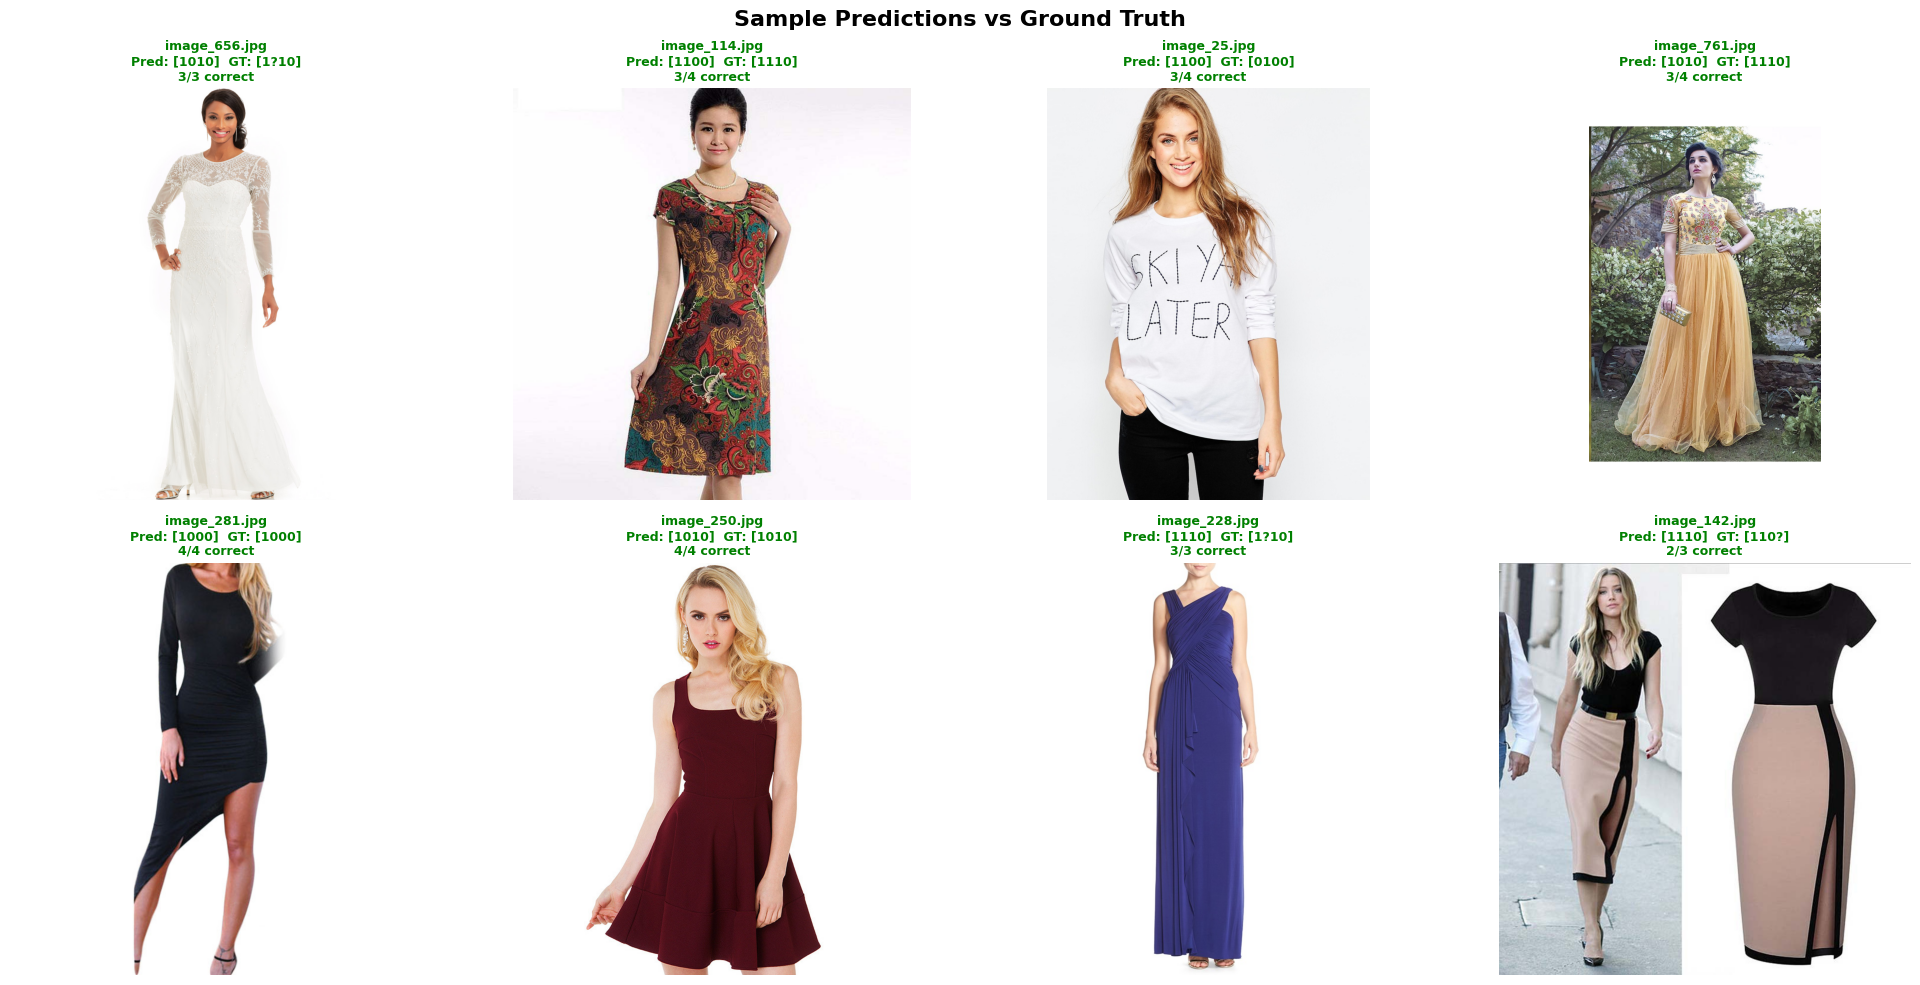

✅ Visualization saved to Drive!


In [33]:
# ============================================================
# CELL 15: VISUALIZE PREDICTIONS ON SAMPLE IMAGES
# ============================================================
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

SAVE_DIR = '/content/drive/MyDrive/AIMonk_Assignment/'

random.seed(42)
sample_indices = random.sample(range(len(filenames)), 8)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Sample Predictions vs Ground Truth', fontsize=16, fontweight='bold')

for idx, ax in zip(sample_indices, axes.flatten()):
    fname = filenames[idx]
    img_path = os.path.join(IMAGE_DIR, fname)

    # Load and show image
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')

    # Get prediction
    result = predict(img_path, model, device, threshold=0.5)
    preds = result['binary']
    confs = result['probabilities']

    # Get ground truth
    gt = labels_array[idx]
    mask = mask_array[idx]

    # Build title
    pred_str = ''.join([str(int(p)) for p in preds])
    gt_str = ''.join([str(int(g)) if m == 1 else '?' for g, m in zip(gt, mask)])

    # Color: green if mostly correct, red if mostly wrong
    correct = sum(1 for p, g, m in zip(preds, gt, mask) if m == 1 and p == g)
    valid = sum(mask)
    color = 'green' if valid > 0 and correct/valid >= 0.5 else 'red'

    ax.set_title(f'{fname}\nPred: [{pred_str}]  GT: [{gt_str}]\n'
                 f'{correct}/{int(valid)} correct',
                 fontsize=9, color=color, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'sample_predictions.png'), dpi=150, bbox_inches='tight')
plt.show()
print("✅ Visualization saved to Drive!")

In [34]:
%%writefile /content/drive/MyDrive/AIMonk_Assignment/train.py
"""
AIMonk Multilabel Classification — Training Script
===================================================
Architecture: ResNet-34 (partially frozen, ImageNet pretrained)
Loss: Masked Weighted BCE (handles missing labels + class imbalance)

Usage: python train.py
"""

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

# ── CONFIG ──────────────────────────────────────────────────
CONFIG = {
    'data_dir': './Multilabel/',
    'image_dir': './Multilabel/images/',
    'label_file': './Multilabel/labels.txt',
    'save_dir': './output/',
    'batch_size': 32,
    'num_epochs': 8,
    'lr': 1e-4,
    'weight_decay': 1e-4,
    'dropout': 0.4,
    'num_workers': 2,
    'image_size': 224,
    'seed': 42,
}

os.makedirs(CONFIG['save_dir'], exist_ok=True)
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# ── PARSE LABELS ────────────────────────────────────────────
df = pd.read_csv(CONFIG['label_file'], sep=r'\s+', header=None,
                 names=['filename', 'attr1', 'attr2', 'attr3', 'attr4'])

# Find missing images
missing = []
for f in df['filename']:
    if not os.path.exists(os.path.join(CONFIG['image_dir'], f)):
        missing.append(f)
print(f"Missing images: {missing}")

df_clean = df[~df['filename'].isin(missing)].reset_index(drop=True)
attr_cols = ['attr1', 'attr2', 'attr3', 'attr4']

# Build labels and masks
labels_array = np.zeros((len(df_clean), 4), dtype=np.float32)
mask_array = np.zeros((len(df_clean), 4), dtype=np.float32)

for i, col in enumerate(attr_cols):
    for j in range(len(df_clean)):
        val = str(df_clean[col].iloc[j]).strip()
        if val in ['0', '0.0']:
            labels_array[j, i] = 0.0
            mask_array[j, i] = 1.0
        elif val in ['1', '1.0']:
            labels_array[j, i] = 1.0
            mask_array[j, i] = 1.0
        else:
            labels_array[j, i] = 0.0
            mask_array[j, i] = 0.0

filenames = df_clean['filename'].values

# Compute pos_weights
pos_weights = []
for i in range(4):
    valid = mask_array[:, i] == 1
    pos = labels_array[valid, i].sum()
    neg = valid.sum() - pos
    w = neg / pos if pos > 0 else 1.0
    pos_weights.append(w)
    print(f"  Attr{i+1}: pos={int(pos)}, neg={int(neg)}, weight={w:.3f}")

pos_weight_tensor = torch.tensor(pos_weights, dtype=torch.float32).to(device)

# ── TRAIN/VAL SPLIT ────────────────────────────────────────
attr4_labels = labels_array[:, 3].copy()
attr4_valid = mask_array[:, 3] == 1
attr4_for_split = np.where(attr4_valid, attr4_labels, -1)
stratify_col = (attr4_for_split * 2 + mask_array[:, 3]).astype(int)

train_idx, val_idx = train_test_split(
    np.arange(len(filenames)), test_size=0.15, random_state=CONFIG['seed'],
    stratify=stratify_col
)
print(f"Train: {len(train_idx)} | Val: {len(val_idx)}")

# ── AUGMENTATION ────────────────────────────────────────────
train_transform = A.Compose([
    A.Resize(CONFIG['image_size'], CONFIG['image_size']),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Rotate(limit=20, p=0.3),
    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1, p=0.5),
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),
    A.GaussNoise(var_limit=(10, 50), p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=15, p=0.3),
    A.CoarseDropout(max_holes=4, max_height=32, max_width=32, p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(CONFIG['image_size'], CONFIG['image_size']),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# ── DATASET ─────────────────────────────────────────────────
class MultilabelDataset(Dataset):
    def __init__(self, fnames, labels, masks, img_dir, transform=None):
        self.fnames = fnames
        self.labels = labels
        self.masks = masks
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.fnames[idx])
        img = np.array(Image.open(img_path).convert('RGB'))
        if self.transform:
            img = self.transform(image=img)['image']
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        mask = torch.tensor(self.masks[idx], dtype=torch.float32)
        return img, label, mask

train_ds = MultilabelDataset(filenames[train_idx], labels_array[train_idx],
                              mask_array[train_idx], CONFIG['image_dir'], train_transform)
val_ds = MultilabelDataset(filenames[val_idx], labels_array[val_idx],
                            mask_array[val_idx], CONFIG['image_dir'], val_transform)

train_loader = DataLoader(train_ds, batch_size=CONFIG['batch_size'], shuffle=True,
                          num_workers=CONFIG['num_workers'], pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False,
                        num_workers=CONFIG['num_workers'], pin_memory=True)

# ── LOSS ────────────────────────────────────────────────────
class MaskedWeightedBCELoss(nn.Module):
    def __init__(self, pos_weight):
        super().__init__()
        self.register_buffer('pos_weight', pos_weight)

    def forward(self, logits, targets, masks):
        bce = nn.functional.binary_cross_entropy_with_logits(
            logits, targets, pos_weight=self.pos_weight, reduction='none'
        )
        masked = bce * masks
        if masks.sum() > 0:
            return masked.sum() / masks.sum()
        return masked.sum()

# ── MODEL ───────────────────────────────────────────────────
class ProductionResNet34(nn.Module):
    def __init__(self, num_classes=4, dropout=0.4):
        super().__init__()
        self.backbone = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)

        # Freeze early layers
        for name, param in self.backbone.named_parameters():
            if any(name.startswith(prefix) for prefix in ['conv1', 'bn1', 'layer1', 'layer2']):
                param.requires_grad = False

        # Replace FC head
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

model = ProductionResNet34(num_classes=4, dropout=CONFIG['dropout']).to(device)
criterion = MaskedWeightedBCELoss(pos_weight_tensor).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                             lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])

# ── TRAINING LOOP ───────────────────────────────────────────
best_f1 = 0
all_iter_losses = []
global_iter = 0

for epoch in range(CONFIG['num_epochs']):
    # Train
    model.train()
    epoch_loss = 0
    for batch_idx, (images, labels, masks) in enumerate(train_loader):
        images, labels, masks = images.to(device), labels.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        global_iter += 1
        all_iter_losses.append((global_iter, loss.item()))

    avg_train_loss = epoch_loss / len(train_loader)

    # Validate
    model.eval()
    all_preds, all_labels, all_masks = [], [], []
    val_loss = 0

    with torch.no_grad():
        for images, labels, masks in val_loader:
            images, labels, masks = images.to(device), labels.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels, masks)
            val_loss += loss.item()

            probs = torch.sigmoid(outputs)
            all_preds.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_masks.append(masks.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_masks = np.concatenate(all_masks)

    binary_preds = (all_preds > 0.5).astype(int)

    f1_scores = []
    for i in range(4):
        valid = all_masks[:, i] == 1
        if valid.sum() > 0:
            p, r, f1, _ = precision_recall_fscore_support(
                all_labels[valid, i], binary_preds[valid, i], average='binary', zero_division=0
            )
            f1_scores.append(f1)
            print(f"  Attr{i+1}: P={p:.3f} R={r:.3f} F1={f1:.3f}")

    avg_f1 = np.mean(f1_scores) if f1_scores else 0
    print(f"Epoch {epoch+1}/{CONFIG['num_epochs']} | "
          f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Avg F1: {avg_f1:.4f}")

    if avg_f1 > best_f1:
        best_f1 = avg_f1
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'val_loss': avg_val_loss,
            'avg_f1': best_f1,
            'pos_weights': pos_weights,
            'model_name': 'resnet34',
            'num_attributes': 4,
            'dropout': CONFIG['dropout'],
            'image_size': CONFIG['image_size'],
            'imagenet_mean': [0.485, 0.456, 0.406],
            'imagenet_std': [0.229, 0.224, 0.225],
        }, os.path.join(CONFIG['save_dir'], 'best_model.pth'))
        print(f"  ★ New best model saved! F1={best_f1:.4f}")

print(f"\n✅ Training complete! Best F1: {best_f1:.4f}")

# ── SAVE LOSS CURVE ─────────────────────────────────────────
iters = [x[0] for x in all_iter_losses]
losses = [x[1] for x in all_iter_losses]

plt.figure(figsize=(10, 6))
plt.plot(iters, losses, alpha=0.3, color='blue', label='Raw')

window = 10
if len(losses) > window:
    smoothed = np.convolve(losses, np.ones(window)/window, mode='valid')
    plt.plot(range(window, len(losses)+1), smoothed, color='red', linewidth=2, label='Smoothed')

plt.xlabel('iteration_number')
plt.ylabel('training_loss')
plt.title('Aimonk_multilabel_problem')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['save_dir'], 'loss_curve.png'), dpi=150, bbox_inches='tight')
print("✅ Loss curve saved!")

Writing /content/drive/MyDrive/AIMonk_Assignment/train.py


In [35]:
%%writefile /content/drive/MyDrive/AIMonk_Assignment/inference.py
"""
AIMonk Multilabel Classification — Inference Script
====================================================
Usage: python inference.py --image path/to/image.jpg --model best_model.pth
"""

import argparse
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision import models
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ── MODEL ARCHITECTURE ──────────────────────────────────────
class ProductionResNet34(nn.Module):
    def __init__(self, num_classes=4, dropout=0.4):
        super().__init__()
        self.backbone = models.resnet34(weights=None)
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

# ── PREPROCESSING ───────────────────────────────────────────
transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

ATTR_NAMES = ['Attribute 1', 'Attribute 2', 'Attribute 3', 'Attribute 4']

# ── PREDICT ─────────────────────────────────────────────────
def predict(image_path, model_path, threshold=0.5, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load model
    model = ProductionResNet34(num_classes=4, dropout=0.4).to(device)
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Load and preprocess image
    img = np.array(Image.open(image_path).convert('RGB'))
    transformed = transform(image=img)['image'].unsqueeze(0).to(device)

    # Inference
    with torch.no_grad():
        logits = model(transformed)
        probs = torch.sigmoid(logits).cpu().numpy()[0]

    binary = (probs > threshold).astype(int)

    # Print results
    print(f"\n{'='*50}")
    print(f"  IMAGE: {image_path}")
    print(f"  THRESHOLD: {threshold}")
    print(f"{'─'*50}")

    present = []
    for i, (name, prob, pred) in enumerate(zip(ATTR_NAMES, probs, binary)):
        status = "PRESENT" if pred == 1 else "ABSENT"
        symbol = "✓" if pred == 1 else "✗"
        print(f"  {symbol} {name}: {status}  (confidence: {prob*100:.1f}%)")
        if pred == 1:
            present.append(name)

    print(f"{'─'*50}")
    if present:
        print(f"  Attributes present: {present}")
    else:
        print(f"  No attributes detected.")
    print(f"{'='*50}")

    return {'probabilities': probs, 'binary': binary, 'present': present}

# ── MAIN ────────────────────────────────────────────────────
if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Multilabel Image Classification Inference')
    parser.add_argument('--image', type=str, required=True, help='Path to input image')
    parser.add_argument('--model', type=str, default='best_model.pth', help='Path to model weights')
    parser.add_argument('--threshold', type=float, default=0.5, help='Classification threshold')
    args = parser.parse_args()

    predict(args.image, args.model, args.threshold)

Writing /content/drive/MyDrive/AIMonk_Assignment/inference.py


In [36]:
# ============================================================
# VERIFY ALL FILES & FINAL CHECKLIST
# ============================================================
import os

SAVE_DIR = '/content/drive/MyDrive/AIMonk_Assignment/'

print("=" * 60)
print("📁 FILES IN GOOGLE DRIVE")
print("=" * 60)

required_files = [
    'best_model.pth',
    'loss_curve.png',
    'train.py',
    'inference.py',
    'README.md',
    'sample_predictions.png',
]

all_present = True
for fname in required_files:
    path = os.path.join(SAVE_DIR, fname)
    exists = os.path.exists(path)
    if exists:
        size = os.path.getsize(path)
        if size > 1024*1024:
            print(f"  ✅ {size/(1024*1024):.2f} MB  {fname}")
        else:
            print(f"  ✅ {size/1024:.1f} KB  {fname}")
    else:
        print(f"  ❌ MISSING   {fname}")
        all_present = False

print(f"\n{'='*60}")
print("📋 FINAL CHECKLIST")
print(f"{'='*60}")
print(f"  {'✅' if all_present else '❌'} All required files in Drive")
print(f"  ⬜ Save notebook (.ipynb) to Drive")
print(f"  ⬜ Create GitHub repo (PUBLIC)")
print(f"  ⬜ Push all files to GitHub")
print(f"  ⬜ Share Drive folder with sourabh@aimonk.com")
print(f"  ⬜ Share Drive folder with deepika@aimonk.com")
print(f"\n  📅 Deadline: Monday, 23 Feb 2026")
print(f"{'='*60}")

📁 FILES IN GOOGLE DRIVE
  ✅ 81.34 MB  best_model.pth
  ✅ 121.8 KB  loss_curve.png
  ✅ 11.2 KB  train.py
  ✅ 3.5 KB  inference.py
  ✅ 4.5 KB  README.md
  ✅ 1.93 MB  sample_predictions.png

📋 FINAL CHECKLIST
  ✅ All required files in Drive
  ⬜ Save notebook (.ipynb) to Drive
  ⬜ Create GitHub repo (PUBLIC)
  ⬜ Push all files to GitHub
  ⬜ Share Drive folder with sourabh@aimonk.com
  ⬜ Share Drive folder with deepika@aimonk.com

  📅 Deadline: Monday, 23 Feb 2026
